In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cmocean.cm as cmo 
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PolyCollection
from scipy.spatial import Delaunay

from scipy.interpolate import griddata
from scipy.spatial import KDTree

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# View from top


## Data

In [20]:
# get the data
path2 = '/Users/georgiamcquade/Documents/GitHub/UFEMISM2.0/automated_testing/integrated_tests/idealised/Thule/Lad/300y/'
Lad1 = xr.open_dataset(path2 + 'main_output_ANT_00001.nc')
Lad2 = xr.open_dataset(path2 + 'main_output_ANT_00002.nc')
Lad1 = xr.open_dataset(path2 + 'main_output_ANT_00003.nc')

In [21]:
Lad3

<xarray.Dataset> Size: 45MB
Dimensions:                     (two: 2, vi: 12600, ci: 32, three: 3,
                                 ti: 24936, ei: 37535, four: 4, vori: 25202,
                                 bin: 11, time: 4, zeta: 12, month: 12,
                                 depth: 16)
Coordinates:
  * time                        (time) float64 32B 270.0 280.0 290.0 300.0
  * zeta                        (zeta) float64 96B 0.0 0.09091 ... 0.9091 1.0
  * month                       (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                       (depth) float64 128B 0.0 100.0 ... 1.5e+03
Dimensions without coordinates: two, vi, ci, three, ti, ei, four, vori, bin
Data variables: (12/79)
    xmin                        float64 8B ...
    xmax                        float64 8B ...
    ymin                        float64 8B ...
    ymax                        float64 8B ...
    tol_dist                    float64 8B ...
    lambda_M                    float64 8B ...
    ...                          ...
    basal_shear_stress          (time, vi) float64 403kB ...
    S_ocean                     (depth, vi) float64 2MB ...
    T_ocean                     (depth, vi) float64 2MB ...
    T_freezing_point            (time, vi) float64 403kB ...
    melt                        (time, vi) float64 403kB ...
    Hib                         (time, vi) float64 403kB ...
Attributes:
    git commit hash:  7c98651c570e1ca1516359c5c4aa3353856d3376 (with uncommit...

In [22]:
# Seperat into variables
Va1 = Lad1['V']
V = Va1.T

Tria1 = Lad1['Tri'] - 1  
Tri = Tria1.T

triang = tri.Triangulation(V[:, 0], V[:, 1], Tri)

Hi_l = Lad1['Hi']
Hib_l = Lad1['Hib']
Hs_l = Lad1['Hs']
Hb_l = Lad1['Hb']
BMB_l = Lad1['BMB']
So = Lad1['S_ocean']
To = Lad1['T_ocean']
T_fp = Lad1['T_freezing_point']
mask_gr = Lad1['mask_grounded_ice']
H_lad = Lad1['H_lad']
T_lad = Lad1['T_lad']

In [23]:
n = 800000
m = n + 100000

In [24]:
#Create the masks

# Ocean 
radius = 750000

distances1 = np.sqrt(V[:, 0]**2 + V[:, 1]**2)
mask_ocean = distances1 <= radius


# Grounded ice
def mask_rock(Hs,Hi,Hb,u):
    p = 0.01
    mask = (Hs[u] - Hi[u] - Hb[u] >= p)
    return mask



In [25]:
Lad1

<xarray.Dataset> Size: 45MB
Dimensions:                     (two: 2, vi: 12600, ci: 32, three: 3,
                                 ti: 24936, ei: 37535, four: 4, vori: 25202,
                                 bin: 11, time: 4, zeta: 12, month: 12,
                                 depth: 16)
Coordinates:
  * time                        (time) float64 32B 270.0 280.0 290.0 300.0
  * zeta                        (zeta) float64 96B 0.0 0.09091 ... 0.9091 1.0
  * month                       (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                       (depth) float64 128B 0.0 100.0 ... 1.5e+03
Dimensions without coordinates: two, vi, ci, three, ti, ei, four, vori, bin
Data variables: (12/79)
    xmin                        float64 8B ...
    xmax                        float64 8B ...
    ymin                        float64 8B ...
    ymax                        float64 8B ...
    tol_dist                    float64 8B ...
    lambda_M                    float64 8B ...
    ...                          ...
    basal_shear_stress          (time, vi) float64 403kB ...
    S_ocean                     (depth, vi) float64 2MB ...
    T_ocean                     (depth, vi) float64 2MB ...
    T_freezing_point            (time, vi) float64 403kB ...
    melt                        (time, vi) float64 403kB ...
    Hib                         (time, vi) float64 403kB ...
Attributes:
    git commit hash:  7c98651c570e1ca1516359c5c4aa3353856d3376 (with uncommit...

In [26]:
mask0 = mask_rock(Hs_l, Hi_l, Hb_l, 0)
mask10 = mask_rock(Hs_l, Hi_l, Hb_l, 1)
mask50 = mask_rock(Hi_l, Hib_l, Hb_l, 3)

In [27]:
u = 0
tfs = 20 
afs = 18 
tifs = 15 
cbfs = 18
ctfs = 15


In [28]:
BMB_q = Lad1['BMB']
BMB_q = BMB_q[0].where(Lad1['Hib'] <(-300))
BMB_q.mean().values 

array(-1.69024216)

In [29]:
def area_weighted_average(vertices, nodal_values):
    vertices = np.asarray(vertices)
    nodal_values = np.asarray(nodal_values)

    valid_mask = ~np.isnan(nodal_values)
    vertices = vertices[valid_mask]
    nodal_values = nodal_values[valid_mask]
    
    try:
        tri = Delaunay(vertices)
    except:
        raise ValueError("Delaunay triangulation failed - check for duplicate points or colinearities")
    
    triangles = tri.points[tri.simplices]  
    
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:,0]*b[:,1] - a[:,1]*b[:,0])
    
    tri_values = nodal_values[tri.simplices]
    tri_means = np.mean(tri_values, axis=1)
    
    total_area = np.sum(areas)
    if total_area == 0:
        return np.nan
    
    return np.sum(areas * tri_means) / total_area


In [30]:
def area_percentage_in_range(vertices, nodal_values, min_val, max_val):
    """
    Calculate the percentage of area where nodal values are within [min_val, max_val].
    
    Parameters:
        vertices (array-like): (N, 2) array of nodal coordinates.
        nodal_values (array-like): (N,) array of nodal values (e.g., ice thickness).
        min_val (float): Lower bound of the range.
        max_val (float): Upper bound of the range.
    
    Returns:
        float: Percentage of area in the specified range (0-100).
    """
    vertices = np.asarray(vertices)
    nodal_values = np.asarray(nodal_values)

    # Remove NaN values
    valid_mask = ~np.isnan(nodal_values)
    vertices = vertices[valid_mask]
    nodal_values = nodal_values[valid_mask]

    try:
        tri = Delaunay(vertices)
    except:
        raise ValueError("Delaunay triangulation failed - check for duplicate points or colinearities")

    triangles = tri.points[tri.simplices]  # (M, 3, 2) array of triangle vertices
    tri_values = nodal_values[tri.simplices]  # (M, 3) array of nodal values per triangle

    # Compute triangle areas
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0])  # (M,) array of areas

    # Check if ANY vertex in the triangle falls within the range
    # (Alternative: check if MEAN of triangle values is in the range)
    in_range_mask = np.any((tri_values >= min_val) & (tri_values <= max_val), axis=1)

    # Sum areas where at least one vertex is in the range
    area_in_range = np.sum(areas[in_range_mask])
    total_area = np.sum(areas)

    if total_area == 0:
        return 0.0  # Avoid division by zero

    return (area_in_range / total_area) * 100  # Return percentage

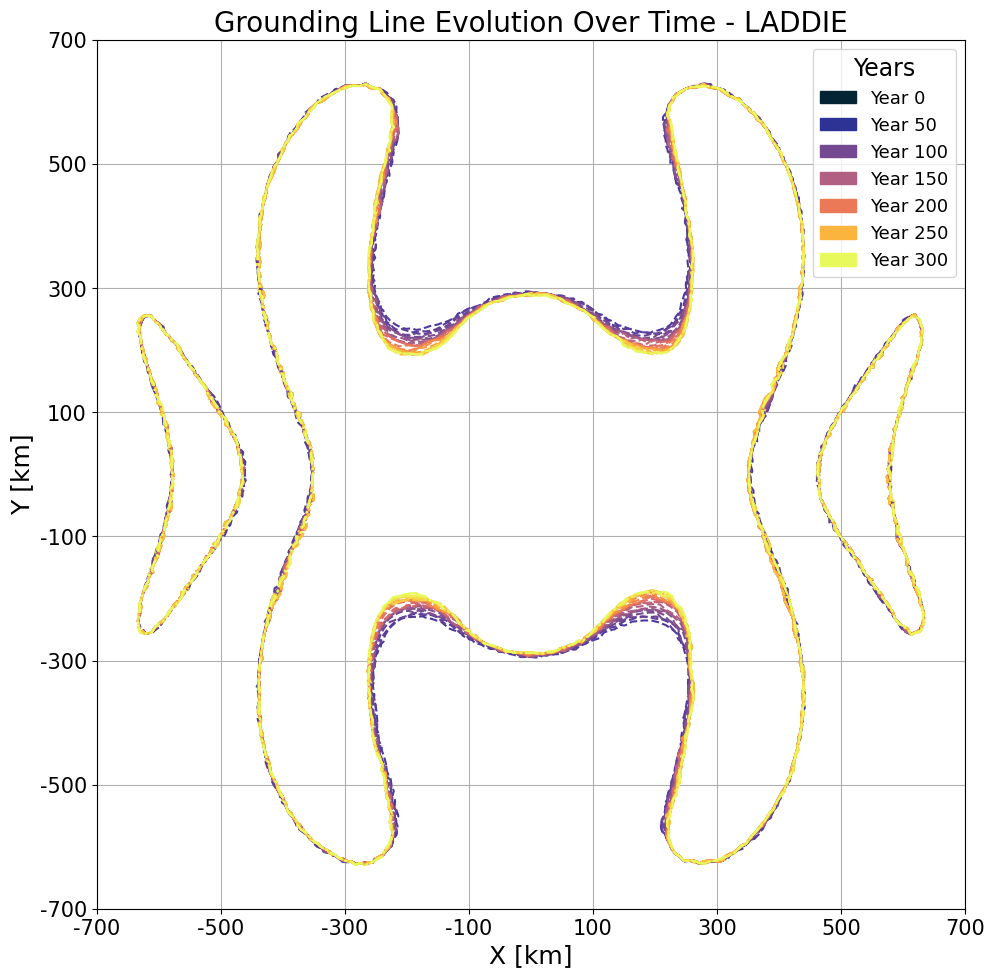

In [31]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 10))

# Define colormap and normalization
cmap = cmo.thermal  
norm = mcolors.Normalize(vmin=0, vmax=300)  # Normalize years from 0 to 300
time_steps_Lad1 = Lad1['time'].values
time_steps_Lad2 = Lad2['time'].values
time_steps_Lad3 = Lad3['time'].values
# Plot Lad1 grounding lines
for t in time_steps_Lad1:
    color = cmap(norm(t))
    L = Lad1['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad1 GL (Year {int(t)})', color=color, linestyle='-')

# Plot Lad2 grounding lines
for t in time_steps_Lad2:
    color = cmap(norm(t))
    L = Lad2['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad2 GL (Year {int(t)})', color=color, linestyle='--')

# Plot Lad3 grounding lines
for t in time_steps_Lad3:
    color = cmap(norm(t))
    L = Lad3['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad3 GL (Year {int(t)})', color=color, linestyle='-.')

# Add legend for every 50 years
legend_handles = []
for year in range(0, 301, 50):
    legend_handles.append(mpatches.Patch(color=cmap(norm(year)), label=f'Year {year}'))

plt.legend(handles=legend_handles, fontsize= tifs-2, loc='upper right', title='Years', title_fontsize=tfs-3)

# Add title, labels, and grid
plt.title('Grounding Line Evolution Over Time - LADDIE', fontsize=tfs)
plt.xlabel('X [km]', fontsize=afs)
# Adjust ticks to display in kilometers
plt.xticks(np.arange(-700000, 700001, 200000), labels=np.arange(-700, 701, 200), fontsize=tifs)
plt.yticks(np.arange(-700000, 700001, 200000), labels=np.arange(-700, 701, 200), fontsize=tifs)
plt.ylabel('Y [km]', fontsize=afs)
plt.grid(True)
plt.xlim(-700000, 700000)
plt.ylim(-700000, 700000)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()




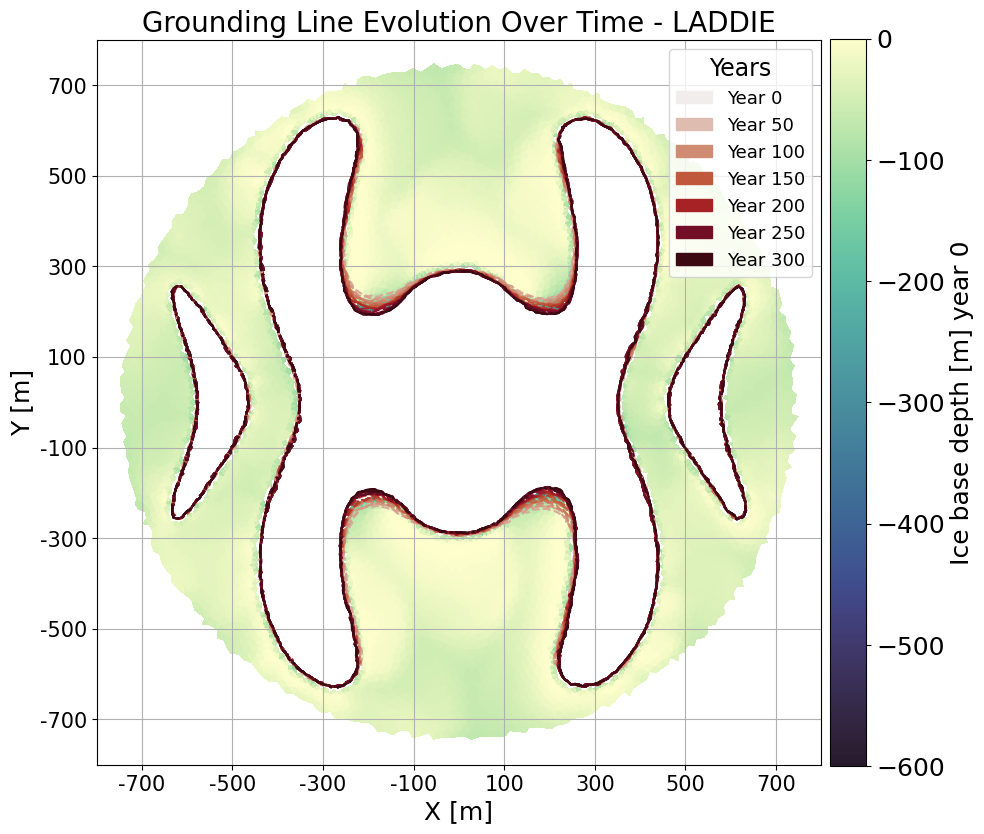

In [32]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.75, 
}

plt.figure(figsize=(10, 10))

# Define colormap and normalization
cmap = cmo.amp  
norm = mcolors.Normalize(vmin=0, vmax=300)  # Normalize years from 0 to 300
time_steps_Lad1 = Lad1['time'].values
time_steps_Lad2 = Lad2['time'].values
time_steps_Lad3 = Lad3['time'].values
# Plot Lad1 grounding lines
for t in time_steps_Lad1:
    color = cmap(norm(t))
    L = Lad1['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad1 GL (Year {int(t)})', color=color, linestyle='-')

# Plot Lad2 grounding lines
for t in time_steps_Lad2:
    color = cmap(norm(t))
    L = Lad2['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad2 GL (Year {int(t)})', color=color, linestyle='--')

# Plot Lad3 grounding lines
for t in time_steps_Lad3:
    color = cmap(norm(t))
    L = Lad3['grounding_line'].sel(time=t)
    plt.plot(L[0, :], L[1, :], label=f'Lad3 GL (Year {int(t)})', color=color, linestyle='-.')

# Add legend for every 50 years
legend_handles = []
for year in range(0, 301, 50):
    legend_handles.append(mpatches.Patch(color=cmap(norm(year)), label=f'Year {year}'))

# Plot initial ice base elevation
c0 = plt.tripcolor(triang, (Hib_l[0]).where(mask_ocean & mask0), cmap=cmo.deep_r, vmin=-600, vmax=0)
cbar = plt.colorbar(c0,**colorbar_kwargs)  # Use plt.colorbar instead of fig.colorbar
cbar.set_label("Ice base depth [m] year 0", fontsize=afs)  # Set fontsize here
cbar.ax.tick_params(labelsize=cbfs)

# Add legend for every 50 years
legend_handles = []
for year in range(0, 301, 50):
    legend_handles.append(mpatches.Patch(color=cmap(norm(year)), label=f'Year {year}'))

plt.legend(handles=legend_handles, fontsize=tifs - 2, loc='upper right', title='Years', title_fontsize=tfs - 3)

# Add title, labels, and grid
plt.title('Grounding Line Evolution Over Time - LADDIE', fontsize=tfs)
plt.xlabel('X [m]', fontsize=afs)
plt.ylabel('Y [m]', fontsize=afs)
plt.grid(True)
plt.xlim(-n, n)
plt.ylim(-n, n)
plt.xticks(np.arange(-700000, 700001, 200000), labels=np.arange(-700, 701, 200), fontsize=tifs)
plt.yticks(np.arange(-700000, 700001, 200000), labels=np.arange(-700, 701, 200), fontsize=tifs)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


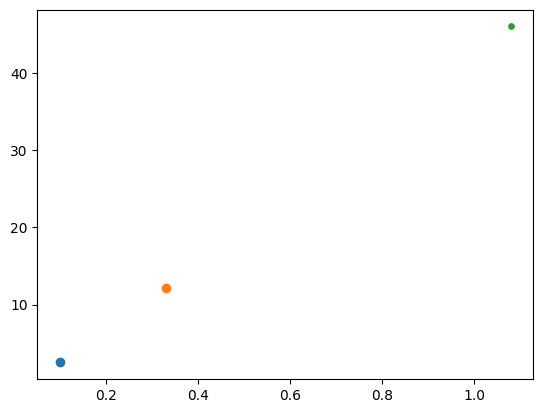

In [33]:
plt.scatter (0.1,2.5)
plt.scatter(0.33,12.12)
plt.scatter( 1.08,46,15)

# Results

## General 

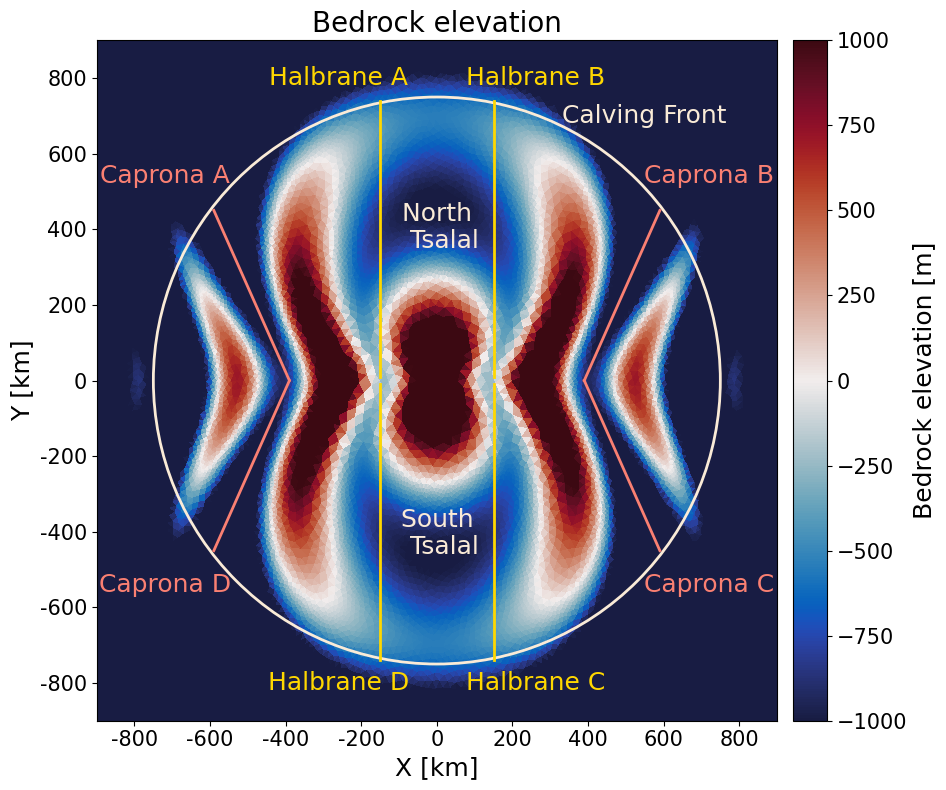

In [ ]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(16, 8)) 

ax.set_title('Bedrock elevation', fontsize=tfs)

c0 = ax.tripcolor(triang, Hb_l[u], cmap=cmo.balance , vmin=-1000, vmax=1000)

cbar = fig.colorbar(c0, ax=ax, label="Bedrock elevation [m]", **colorbar_kwargs)
cbar.ax.tick_params(labelsize=ctfs)
cbar.set_label("Bedrock elevation [m]", fontsize=cbfs)


ax.set_aspect('equal')
ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.tick_params(axis='both', labelsize=tifs)
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-m,m)
ax.set_ylim(-m,m)




circle = plt.Circle((0, 0), 750000, color='antiquewhite', fill=False, linestyle='-', linewidth=2)
ax.add_artist(circle)

ax.plot([150000, 150000], [10000, 740000], color='gold', linestyle='-', linewidth=2)
ax.plot([150000, 150000], [-10000, -740000], color='gold', linestyle='-', linewidth=2)
ax.plot([-150000, -150000], [10000, 740000], color='gold', linestyle='-', linewidth=2)
ax.plot([-150000, -150000], [-10000, -740000], color='gold', linestyle='-', linewidth=2)

ax.text(260000, 800000, 'Halbrane B', fontsize=afs, color='gold', ha='center', va='center')
ax.text(-260000, 800000, 'Halbrane A', fontsize=afs, color='gold', ha='center', va='center')
ax.text(-260000, -800000, 'Halbrane D', fontsize=afs, color='gold', ha='center', va='center')
ax.text(260000, -800000, 'Halbrane C', fontsize=afs, color='gold', ha='center', va='center')

ax.text(0, +440000, ' North ', fontsize=afs, color='antiquewhite', ha='center', va='center')
ax.text(0, +370000, '  Tsalal', fontsize=afs, color='antiquewhite', ha='center', va='center')
ax.text(0, -440000, '  Tsalal', fontsize=afs, color='antiquewhite', ha='center', va='center')
ax.text(0, -370000, ' South ', fontsize=afs, color='antiquewhite', ha='center', va='center')
ax.plot([390000, 590000], [0, 450000], color='salmon', linestyle='-', linewidth=2)
ax.plot([-390000, -590000], [0, 450000], color='salmon', linestyle='-', linewidth=2)
ax.plot([-390000,- 590000], [0, -450000], color='salmon', linestyle='-', linewidth=2)
ax.plot([390000, 590000], [0, -450000], color='salmon', linestyle='-', linewidth=2)

ax.text(720000, 540000, 'Caprona B', fontsize=afs, color='salmon', ha='center', va='center')
ax.text(-720000, 540000, 'Caprona A', fontsize=afs, color='salmon', ha='center', va='center')
ax.text(-720000, - 540000, 'Caprona D', fontsize=afs, color='salmon', ha='center', va='center')
ax.text(720000, - 540000, 'Caprona C', fontsize=afs, color='salmon', ha='center', va='center')

ax.text(550000, 700000, 'Calving Front', fontsize=afs, color='Antiquewhite', ha='center', va='center')

plt.tight_layout()
plt.show()

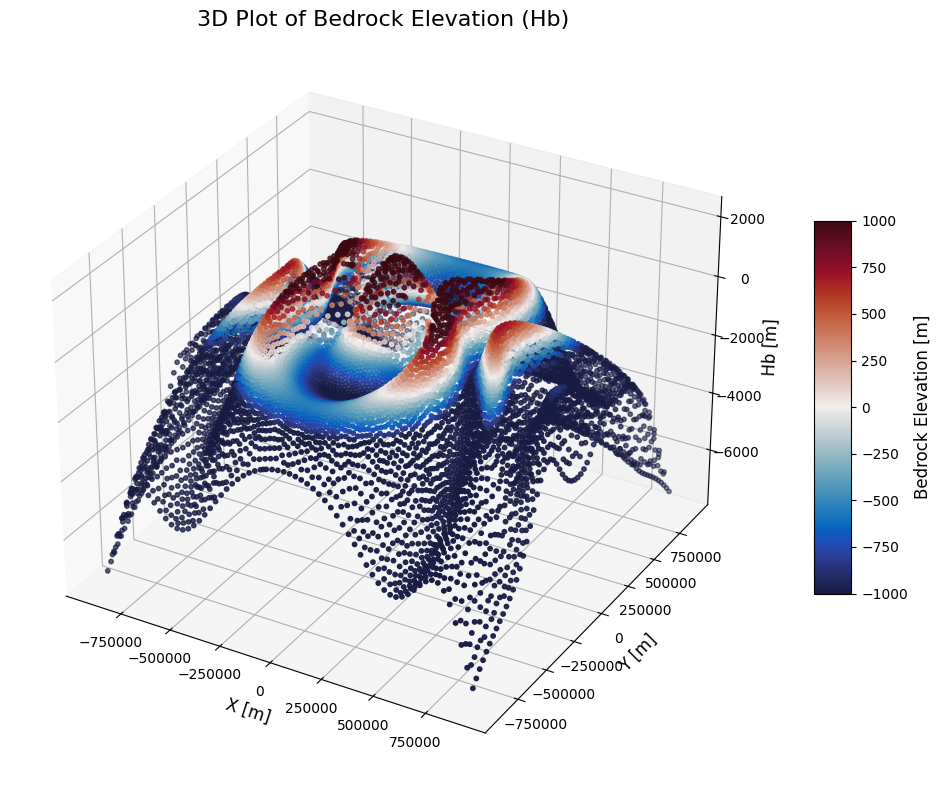

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and values for the plot
x = V[:, 0]
y = V[:, 1]
z = Hb_l[u]

# Create the 3D scatter plot
sc = ax.scatter(x, y, z, c=z, cmap=cmo.balance, marker='o', vmin= -1000 , vmax=1000, s=10)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Bedrock Elevation [m]', fontsize=12)

# Set labels and title
ax.set_title('3D Plot of Bedrock Elevation (Hb)', fontsize=16)
ax.set_xlabel('X [m]', fontsize=12)
ax.set_ylabel('Y [m]', fontsize=12)
ax.set_zlabel('Hb [m]', fontsize=12)

plt.tight_layout()
plt.show()

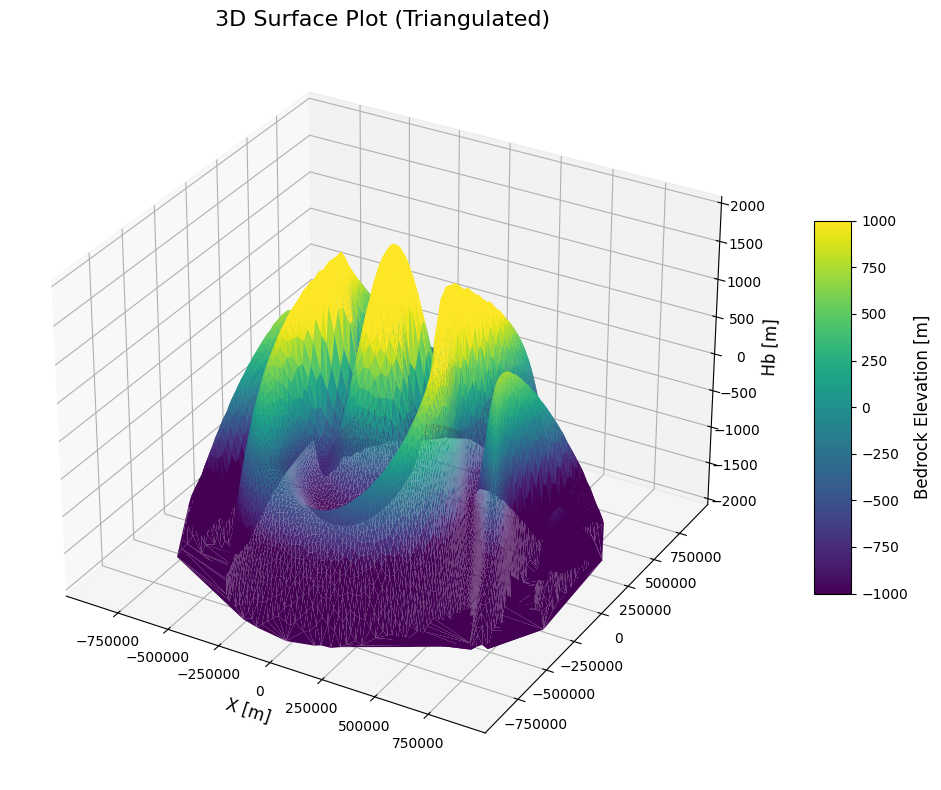

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = V[:, 0]
y = V[:, 1]
z = Hb_l[u]  

# Create a mask for z > -2000
mask = z > -2000

# Apply the mask to x, y, z
x = x[mask]
y = y[mask]
z = z[mask]

# Use Delaunay triangulation for surface plotting (faster than griddata)
surf = ax.plot_trisurf(
    x, y, z, 
    cmap='viridis', 
    vmin=-1000, 
    vmax=1000,
    edgecolor='none',
    antialiased=True,
    #alpha=1 # Optional: makes it slightly transparent
)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Bedrock Elevation [m]', fontsize=12)

ax.set_title('3D Surface Plot (Triangulated)', fontsize=16)
ax.set_xlabel('X [m]', fontsize=12)
ax.set_zlim(-2000, 2000)
ax.set_zlabel('Hb [m]', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
def bed_geometry(x, y, R=800e3, Bc=900, Bl=-2000, Ba=1100):
    """
    Calculate bedrock elevation for the Thule domain geometry
    
    Parameters:
    x, y : array_like
        Coordinate grids (m)
    R : float, optional
        Domain radius (m), default 800 km
    Bc : float, optional
        Central bedrock elevation (m), default 900
    Bl : float, optional
        Minimum bedrock elevation (m), default -2000
    Ba : float, optional
        Bedrock amplitude (m), default 1100
        
    Returns:
    B : ndarray
        Bedrock elevation (m)
    """
    rc = 0  # Core radius
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    l = R - (np.cos(2 * theta) * R) / 2
    a = Bc - (Bc - Bl) * (r - rc)**2 / (R - rc)**2
    B = Ba * np.cos(3 * np.pi * r / l) + a
    
    return B

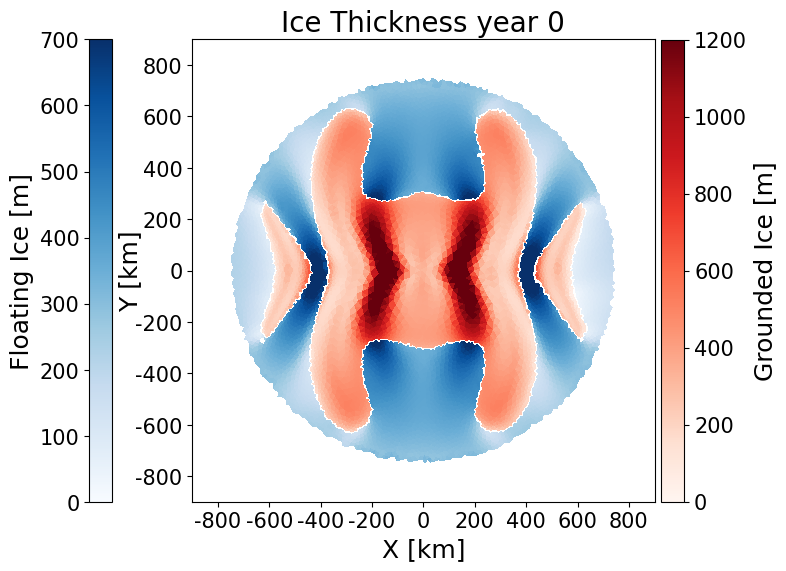

In [ ]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.6, 
    
}

u = 0


tfs = 20 
afs = 18 
tifs = 15 
cbfs = 18
ctfs = 15
##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

# Plot floating ice
c0 = ax.tripcolor(triang, (Hi_l[0]).where(mask_ocean & ~mask0), cmap='Reds', vmin=0, vmax=1200)
# Add color bar for floating ice
cbar0 = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar0.set_label("Grounded Ice [m]", fontsize=cbfs)
cbar0.ax.tick_params(labelsize=ctfs)

# Plot grounfloatinfded ice
c1 = ax.tripcolor(triang, (Hi_l[0]).where(mask_ocean & mask0), cmap='Blues', vmin=0, vmax=700)
# Add color bar for grounded ice on the left
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("left", size="5%", pad=0.8)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_label("Floating Ice [m]", fontsize=cbfs)
cbar1.ax.tick_params(labelsize=ctfs)
cax1.yaxis.set_label_position('left')
cax1.yaxis.tick_left()

ax.set_title('Ice Thickness year 0', fontsize=tfs)
ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs, labelpad=-5)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-m, m)
ax.set_ylim(-m, m)
ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=tifs)

plt.tight_layout()
plt.show()

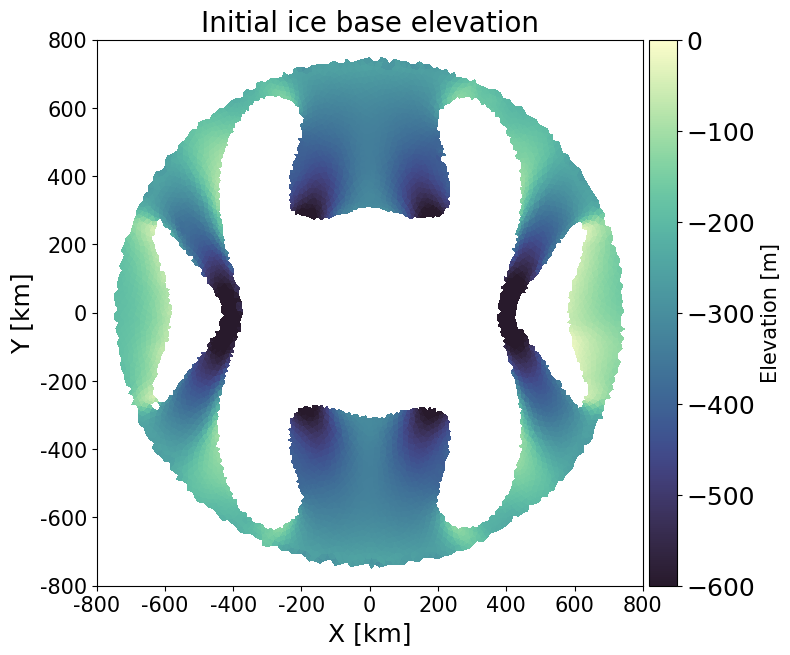

In [ ]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.72, 
}

n = 800000
##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (Hib_l[0]).where(mask_ocean & mask0), cmap=cmo.deep_r, vmin=-600, vmax= 0)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Elevation [m]", fontsize=ctfs)  # Set fontsize here
cbar.ax.tick_params(labelsize=cbfs)
ax.set_title('Initial ice base elevation', fontsize=tfs)



ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

## Ice thickness

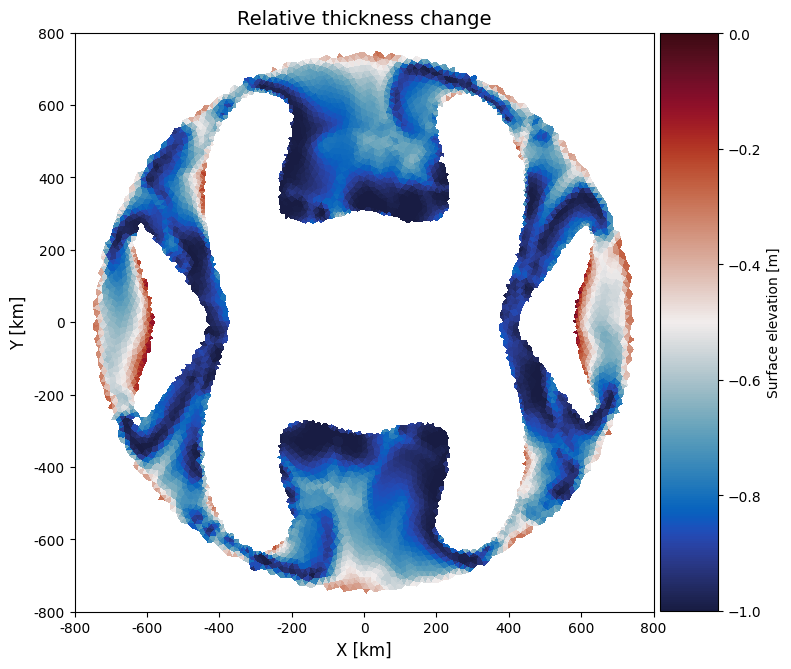

In [223]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (Hi_l[-1]-Hi_l[0])/(Hi_l[0]).where(mask_ocean & mask0), cmap=cmo.balance, vmin=-1, vmax= 0)
fig.colorbar(c0, ax=ax, label="Surface elevation [m]", **colorbar_kwargs)
ax.set_title('Relative thickness change', fontsize=14)

ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [211]:
test = (Hi_l[10].where(mask10)-Hi_l[0].where(mask0)).where(mask_ocean)
posit =  calculate_area_percentages(V, test , [(0,1000)])
posit

[np.float64(0.0)]

In [36]:
Lad1

<xarray.Dataset> Size: 144MB
Dimensions:                     (two: 2, vi: 12428, ci: 32, three: 3,
                                 ti: 24592, ei: 37019, four: 4, vori: 24858,
                                 bin: 11, time: 20, zeta: 12, month: 12,
                                 depth: 16)
Coordinates:
  * time                        (time) float64 160B 70.0 80.0 ... 250.0 260.0
  * zeta                        (zeta) float64 96B 0.0 0.09091 ... 0.9091 1.0
  * month                       (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                       (depth) float64 128B 0.0 100.0 ... 1.5e+03
Dimensions without coordinates: two, vi, ci, three, ti, ei, four, vori, bin
Data variables: (12/79)
    xmin                        float64 8B ...
    xmax                        float64 8B ...
    ymin                        float64 8B ...
    ymax                        float64 8B ...
    tol_dist                    float64 8B ...
    lambda_M                    float64 8B ...
    ...                          ...
    basal_shear_stress          (time, vi) float64 2MB ...
    S_ocean                     (depth, vi) float64 2MB ...
    T_ocean                     (depth, vi) float64 2MB ...
    T_freezing_point            (time, vi) float64 2MB ...
    melt                        (time, vi) float64 2MB ...
    Hib                         (time, vi) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    git commit hash:  7c98651c570e1ca1516359c5c4aa3353856d3376 (with uncommit...

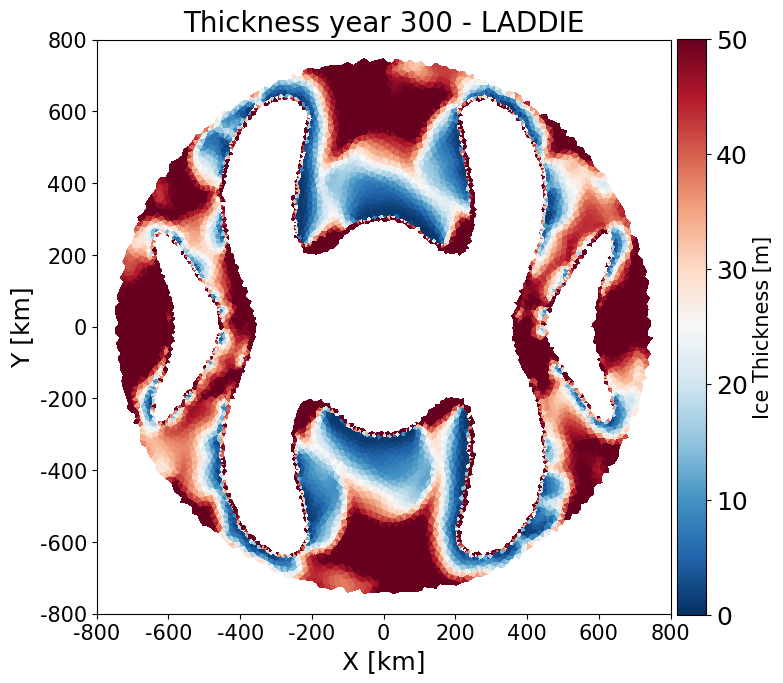

In [39]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.76, 
}


##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (Hi_l[3].where(mask10)).where(mask_ocean), cmap='RdBu_r', vmin=0, vmax=50)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness [m]", fontsize= ctfs)  # Set fontsize here
cbar.ax.tick_params(labelsize=cbfs)
ax.set_title('Thickness year 300 - LADDIE', fontsize=tfs)

ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
area_percentage_in_range( (Hi_l[5].where(mask10)).where(mask_ocean))

In [ ]:
# Extract the data for the histogram
data = (Hi_l[10].where(mask10) - Hi_l[0].where(mask0)).where(mask_ocean).values.flatten()
data = data[~np.isnan(data)]  # Remove NaN values

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Ice Thickness Change (Year 10 - Year 0)', fontsize=16)
plt.xlabel('Ice Thickness Change [m]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


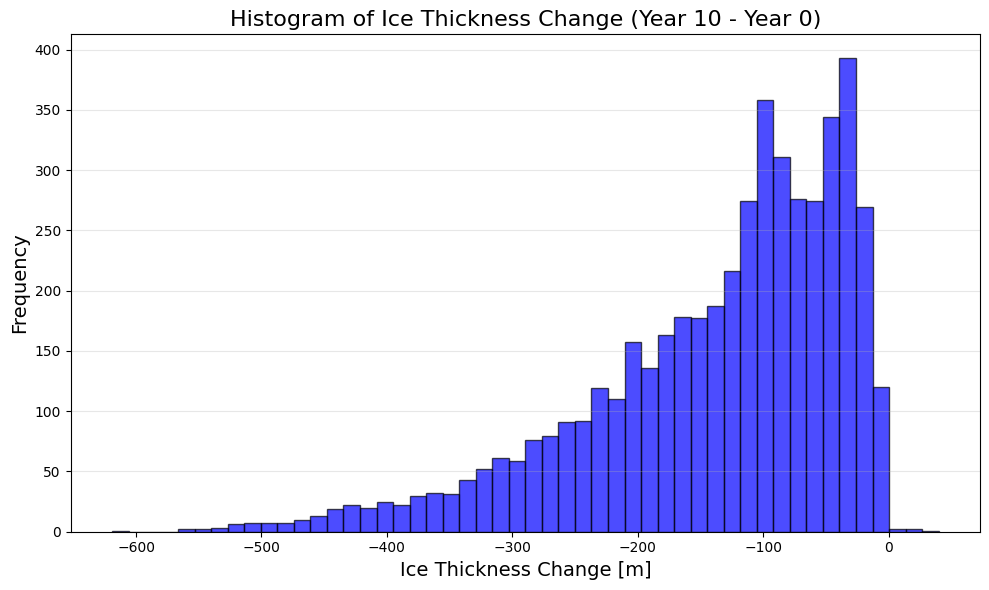

In [216]:
# Extract the data for the histogram
data = (Hi_l[10].where(mask10) - Hi_l[0].where(mask0)).where(mask_ocean).values.flatten()
data = data[~np.isnan(data)]  # Remove NaN values

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Ice Thickness Change (Year 10 - Year 0)', fontsize=16)
plt.xlabel('Ice Thickness Change [m]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [181]:
years = [0, 1,2,3]


In [180]:
def calculate_area_percentages(V, Hi, ranges):
    """
    Calculate percentage of area for each thickness range.
    
    Args:
        V: Array of vertices (N, 2)
        Hi: Array of thickness values (N,)
        ranges: List of tuples defining ranges [(min1, max1), (min2, max2), ...]
    
    Returns:
        List of area percentages for each range
    """
    # Convert inputs and remove NaN values
    vertices = np.asarray(V)
    thickness = np.asarray(Hi)
    valid_mask = ~np.isnan(thickness)
    vertices = vertices[valid_mask]
    thickness = thickness[valid_mask]
    
    # Create triangulation once for all ranges
    try:
        tri = Delaunay(vertices)
    except:
        raise ValueError("Delaunay triangulation failed")
    
    # Get triangles and their properties
    triangles = tri.points[tri.simplices]
    tri_values = thickness[tri.simplices]
    tri_means = np.mean(tri_values, axis=1)
    
    # Calculate triangle areas
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:,0]*b[:,1] - a[:,1]*b[:,0])
    total_area = np.sum(areas)
    
    if total_area == 0:
        return [np.nan] * len(ranges)
    
    # Calculate area percentages for each range
    percentages = []
    for min_val, max_val in ranges:
        in_range = (tri_means >= min_val) & (tri_means < max_val)
        range_area = np.sum(areas[in_range])
        percentages.append((range_area / total_area) * 100)
    
    return percentages[0]



/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_29900/1923894916.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


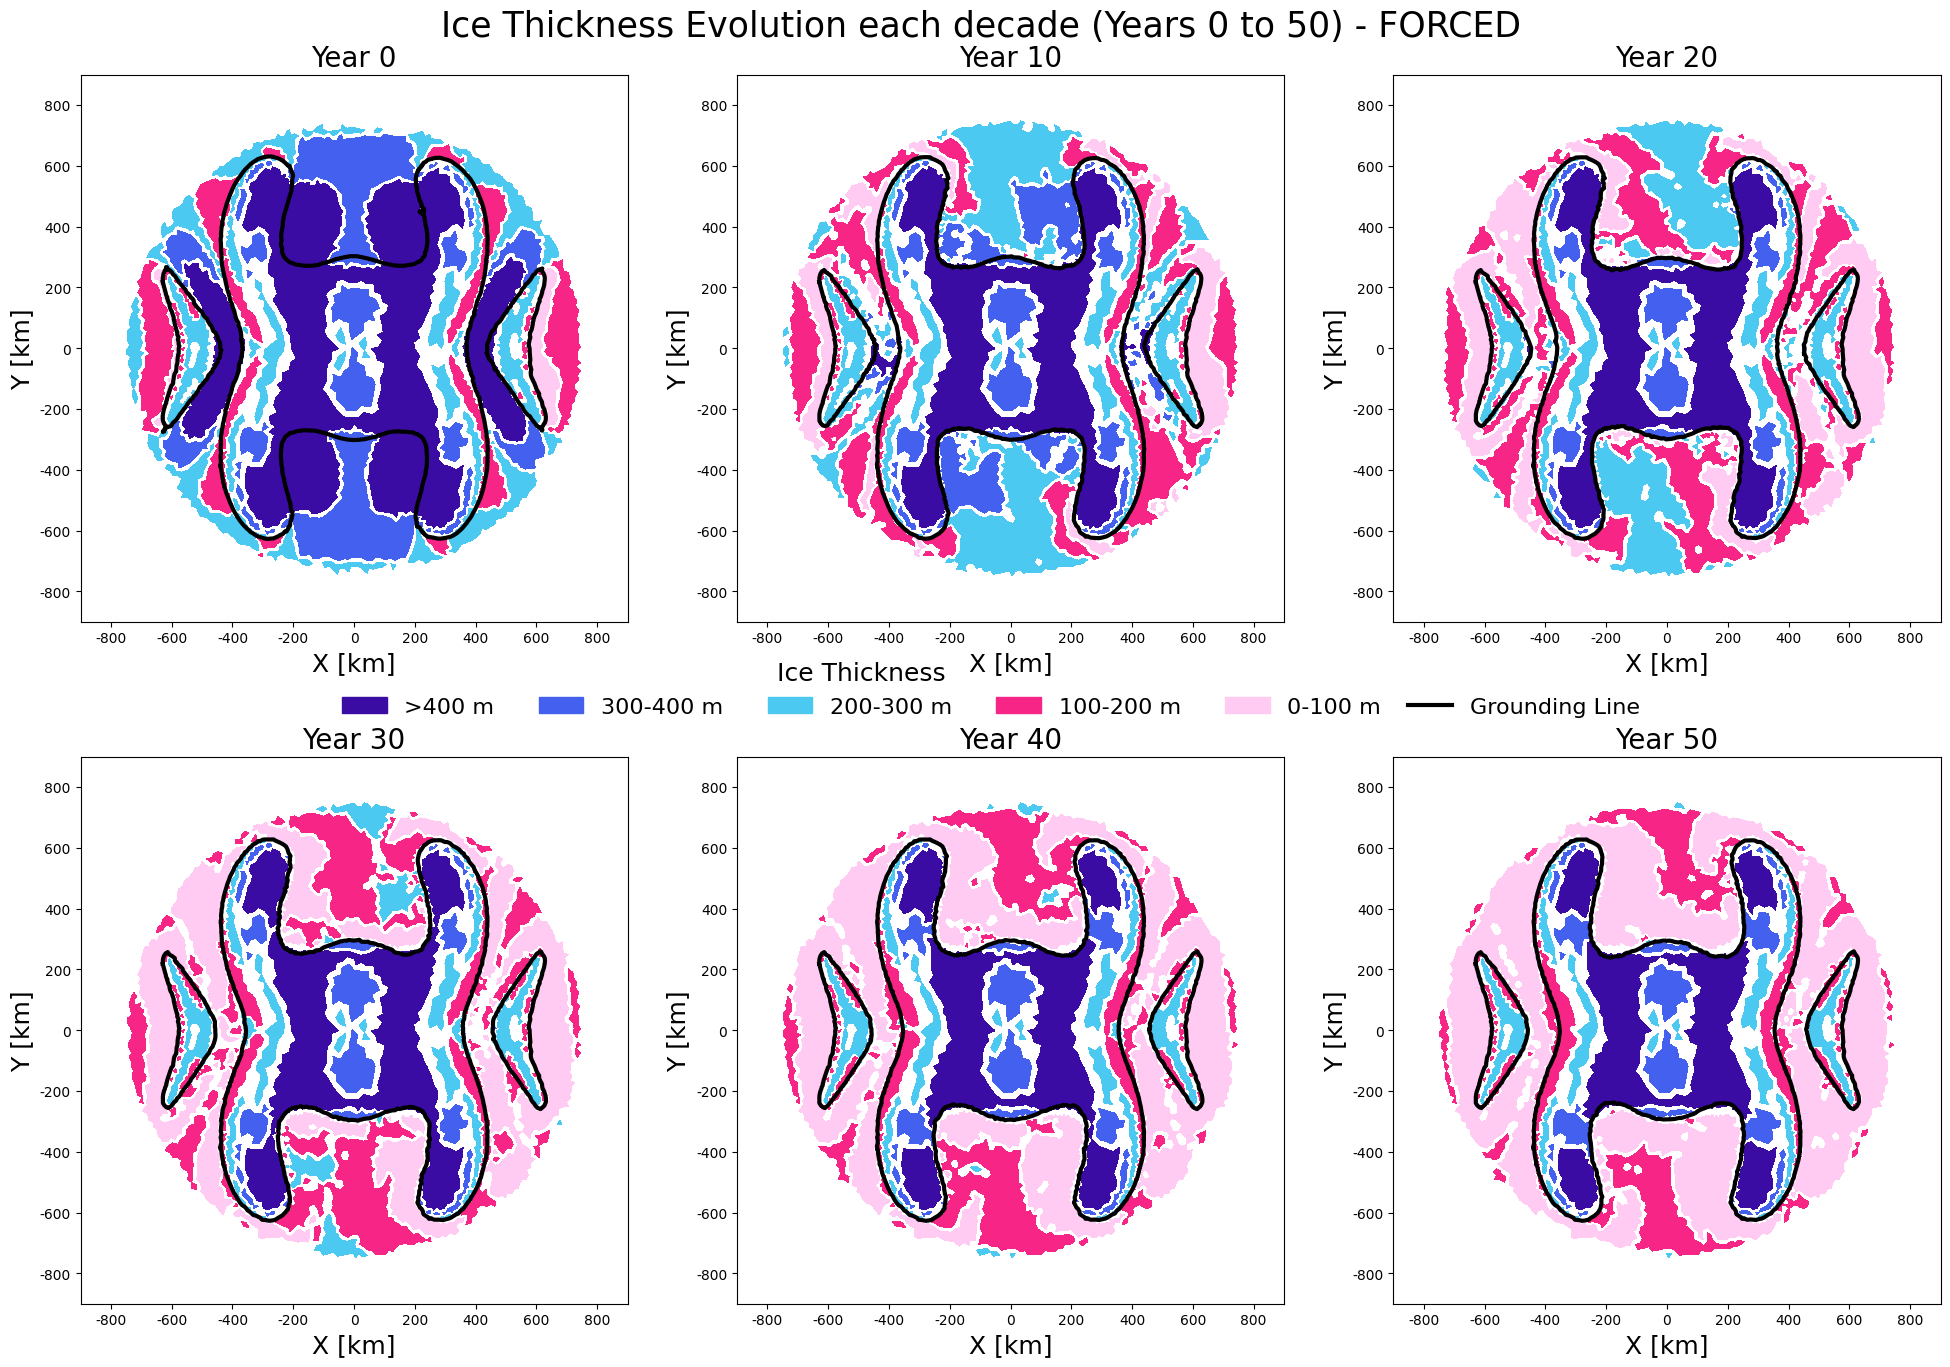

In [94]:
solid_colors = {
    '>400': '#3A0CA3',   # Deep blue
    '300-400': '#4361EE', # Bright blue
    '200-300': '#4CC9F0', # Light teal-blue
    '100-200': '#F72585', # Vibrant pink
    '0-100': '#FFCBF2'    # Light pink
}

# Create colormaps
cmap_grey = ListedColormap([solid_colors['>400']])
cmap_purple = ListedColormap([solid_colors['300-400']])
cmap_blue = ListedColormap([solid_colors['200-300']])
cmap_orange = ListedColormap([solid_colors['100-200']])
cmap_red = ListedColormap([solid_colors['0-100']])



fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.1)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row


legend_handles = [
    mpatches.Patch(color=solid_colors['>400'], label='>400 m'),
    mpatches.Patch(color=solid_colors['300-400'], label='300-400 m'),
    mpatches.Patch(color=solid_colors['200-300'], label='200-300 m'),
    mpatches.Patch(color=solid_colors['100-200'], label='100-200 m'),
    mpatches.Patch(color=solid_colors['0-100'], label='0-100 m')
]




for i, year in enumerate(years):
    ax = axes[i]
    
    # Plot from thinnest to thickest (reverse order)
    c4 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] > 0) & (Hi_l[year] < 100)), cmap=cmap_red)
    c3 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 100) & (Hi_l[year] < 200)), cmap=cmap_orange)
    c2 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 200) & (Hi_l[year] < 300)), cmap=cmap_blue)
    c1 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 300) & (Hi_l[year] < 400)), cmap=cmap_purple)
    c0 = ax.tripcolor(triang, Hi_l[year].where(Hi_l[year] >= 400), cmap=cmap_grey)
    
    # Plot grounding line
    GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')
    
    # Set titles, labels, etc.
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-m, m)
    ax.set_ylim(-m, m)
    ax.set_aspect('equal')

    percentages = calculate_area_percentages(V, Hi_l[year].where(mask50 & mask_ocean), ranges)

   

ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.146), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])  # Span all columns in middle row
legend_ax.axis('off')  # Hide axes
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,  # Display in a single row
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.42, 0.5),
                         title_fontsize=18)  # Increase title font size

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - LADDIE', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_29900/4076202704.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


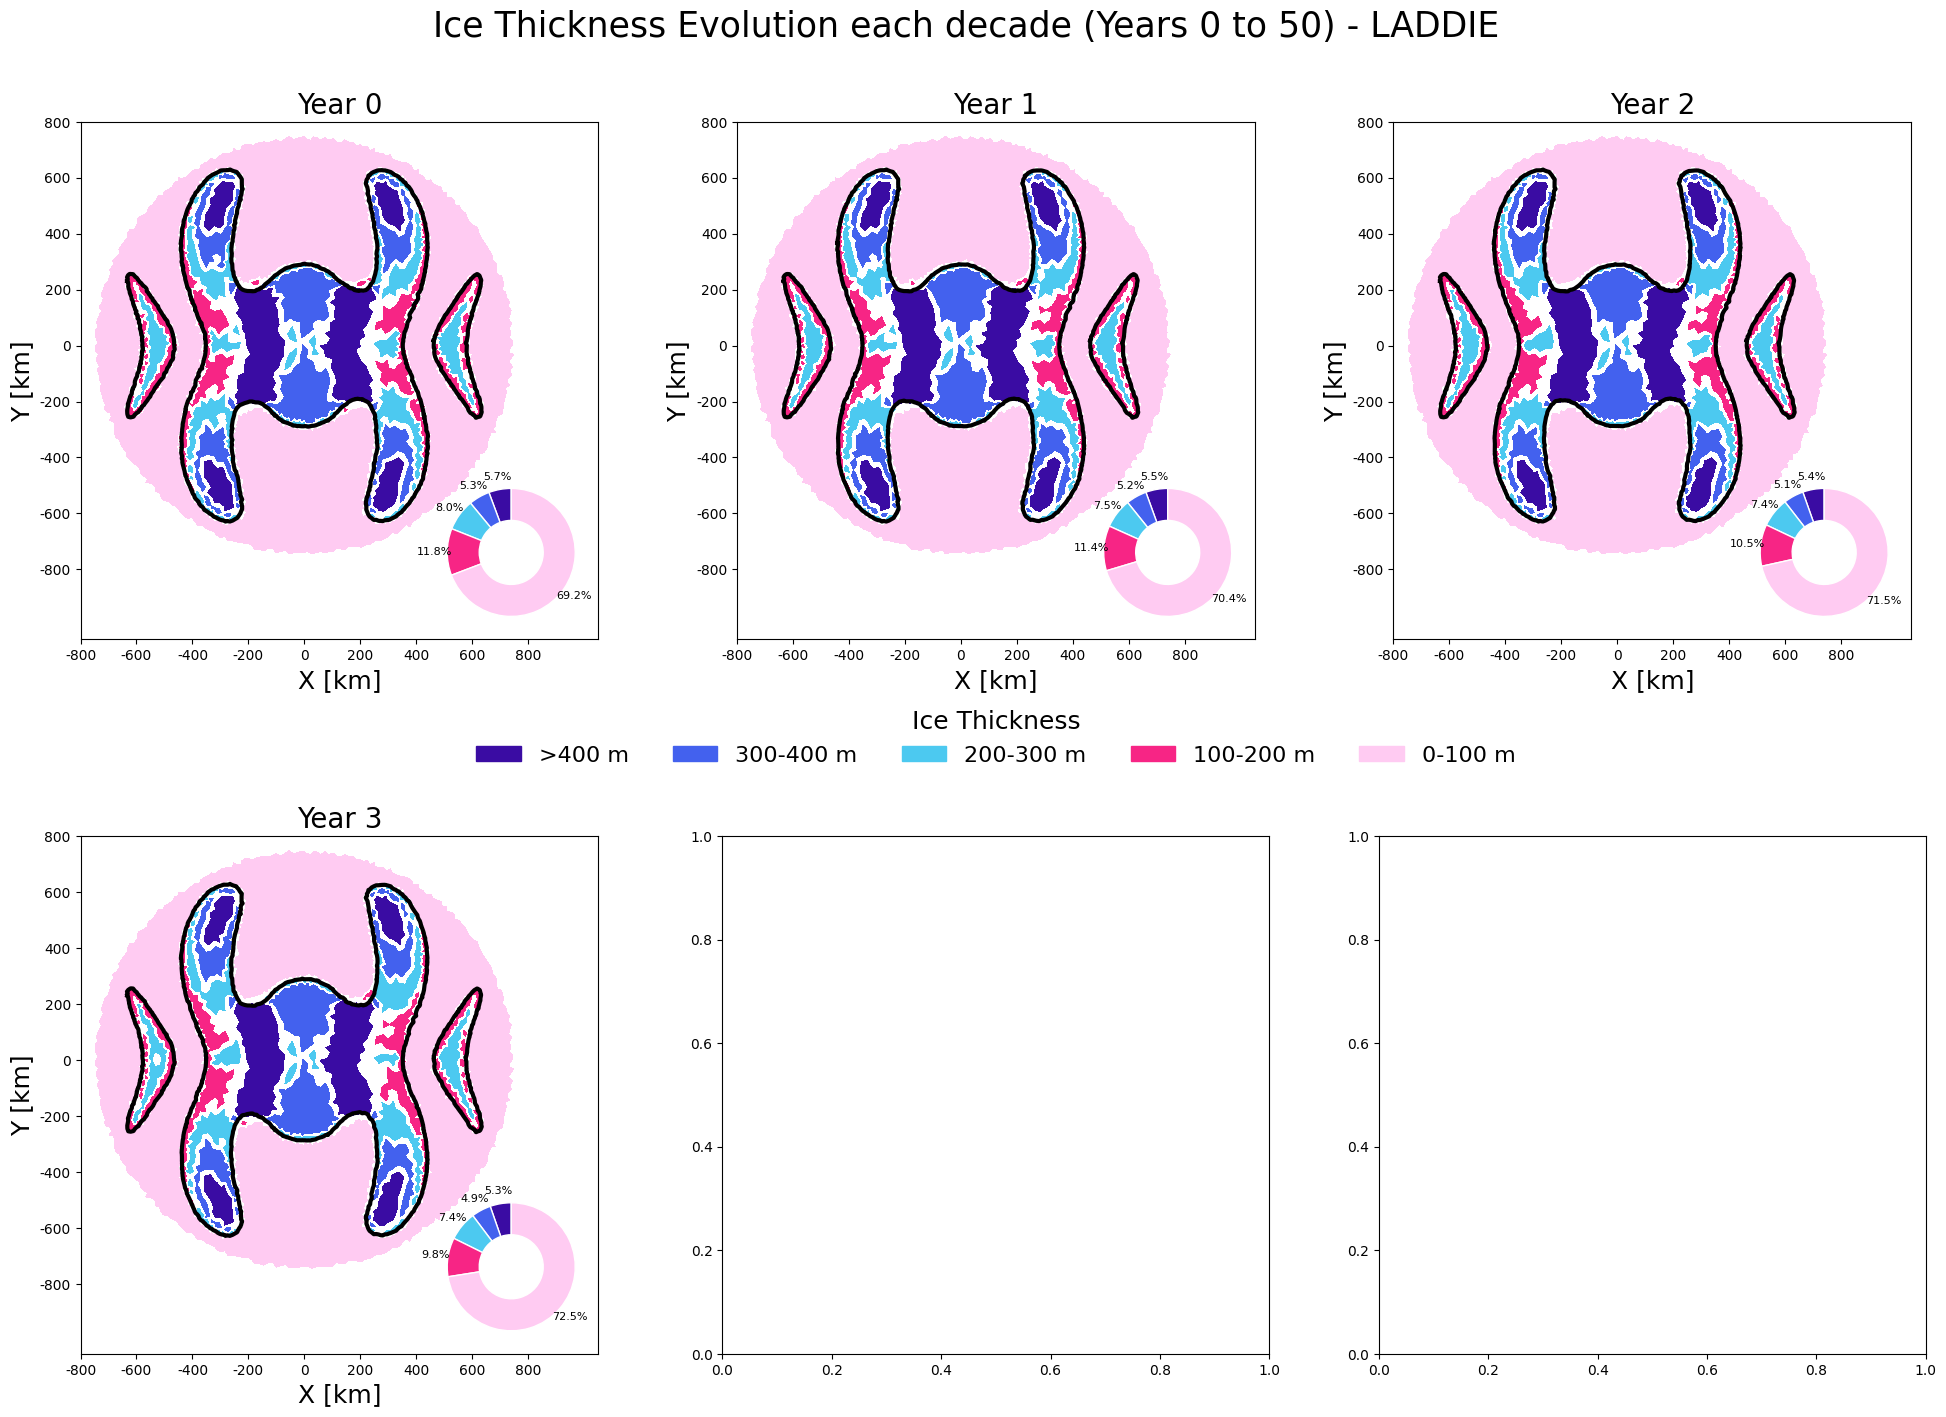

In [182]:
solid_colors = {
    '>400': '#3A0CA3',   # Deep blue
    '300-400': '#4361EE', # Bright blue
    '200-300': '#4CC9F0', # Light teal-blue
    '100-200': '#F72585', # Vibrant pink
    '0-100': '#FFCBF2'    # Light pink
}

# Create colormaps
cmap_grey = ListedColormap([solid_colors['>400']])
cmap_purple = ListedColormap([solid_colors['300-400']])
cmap_blue = ListedColormap([solid_colors['200-300']])
cmap_orange = ListedColormap([solid_colors['100-200']])
cmap_red = ListedColormap([solid_colors['0-100']])

fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    mpatches.Patch(color=solid_colors['>400'], label='>400 m'),
    mpatches.Patch(color=solid_colors['300-400'], label='300-400 m'),
    mpatches.Patch(color=solid_colors['200-300'], label='200-300 m'),
    mpatches.Patch(color=solid_colors['100-200'], label='100-200 m'),
    mpatches.Patch(color=solid_colors['0-100'], label='0-100 m')
]

for i, year in enumerate(years):
    ax = axes[i]
    
    # Plot ice thickness
    c4 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] > 0) & (Hi_l[year] < 100)), cmap=cmap_red)
    c3 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 100) & (Hi_l[year] < 200)), cmap=cmap_orange)
    c2 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 200) & (Hi_l[year] < 300)), cmap=cmap_blue)
    c1 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 300) & (Hi_l[year] < 400)), cmap=cmap_purple)
    c0 = ax.tripcolor(triang, Hi_l[year].where(Hi_l[year] >= 400), cmap=cmap_grey)
    
    # Plot grounding line
    GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')
    
    # Calculate percentages for current year
    hi_data = Hi_l[year].where(mask50 & mask_ocean).values.flatten()
    hi_data = hi_data[~np.isnan(hi_data)]
    total_area = len(hi_data)

    categories = {
        '>400': np.sum(hi_data > 400),
        '300-400': np.sum((hi_data > 300) & (hi_data <= 400)),
        '200-300': np.sum((hi_data > 200) & (hi_data <= 300)),
        '100-200': np.sum((hi_data > 100) & (hi_data <= 200)),
        '0-100': np.sum((hi_data > 0) & (hi_data <= 100))
    }


    sizes = [categories[key] for key in solid_colors.keys()]
    colors = [solid_colors[key] for key in solid_colors.keys()]
    percentages = [f'{size/total_area:.1%}' for size in sizes]
    
    # Add pie chart as inset
    pie_ax = inset_axes(ax, width=1.6, height=1.6, loc='lower right', 
                       bbox_to_anchor=(1, 0.0), bbox_transform=ax.transAxes)
    
    wedges, texts = pie_ax.pie(sizes, colors=colors, startangle=90,
                             wedgeprops=dict(width=0.5, edgecolor='w'))
    
    # Add percentage labels
    for j, wedge in enumerate(wedges):
        angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
        x = 1.2 * np.cos(np.deg2rad(angle))
        y = 1.2 * np.sin(np.deg2rad(angle))
        pie_ax.text(x, y, percentages[j], ha='center', va='center', fontsize=8)
    
    #pie_ax.set_title(f'Year {year}', fontsize=10, pad=5)
    
    # Set main plot properties
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+150000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.5, 0.5),
                         title_fontsize=18)

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - LADDIE', 
             fontsize=tfs+5, y=0.95)  

plt.tight_layout()
plt.show()

/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_29900/3017390043.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


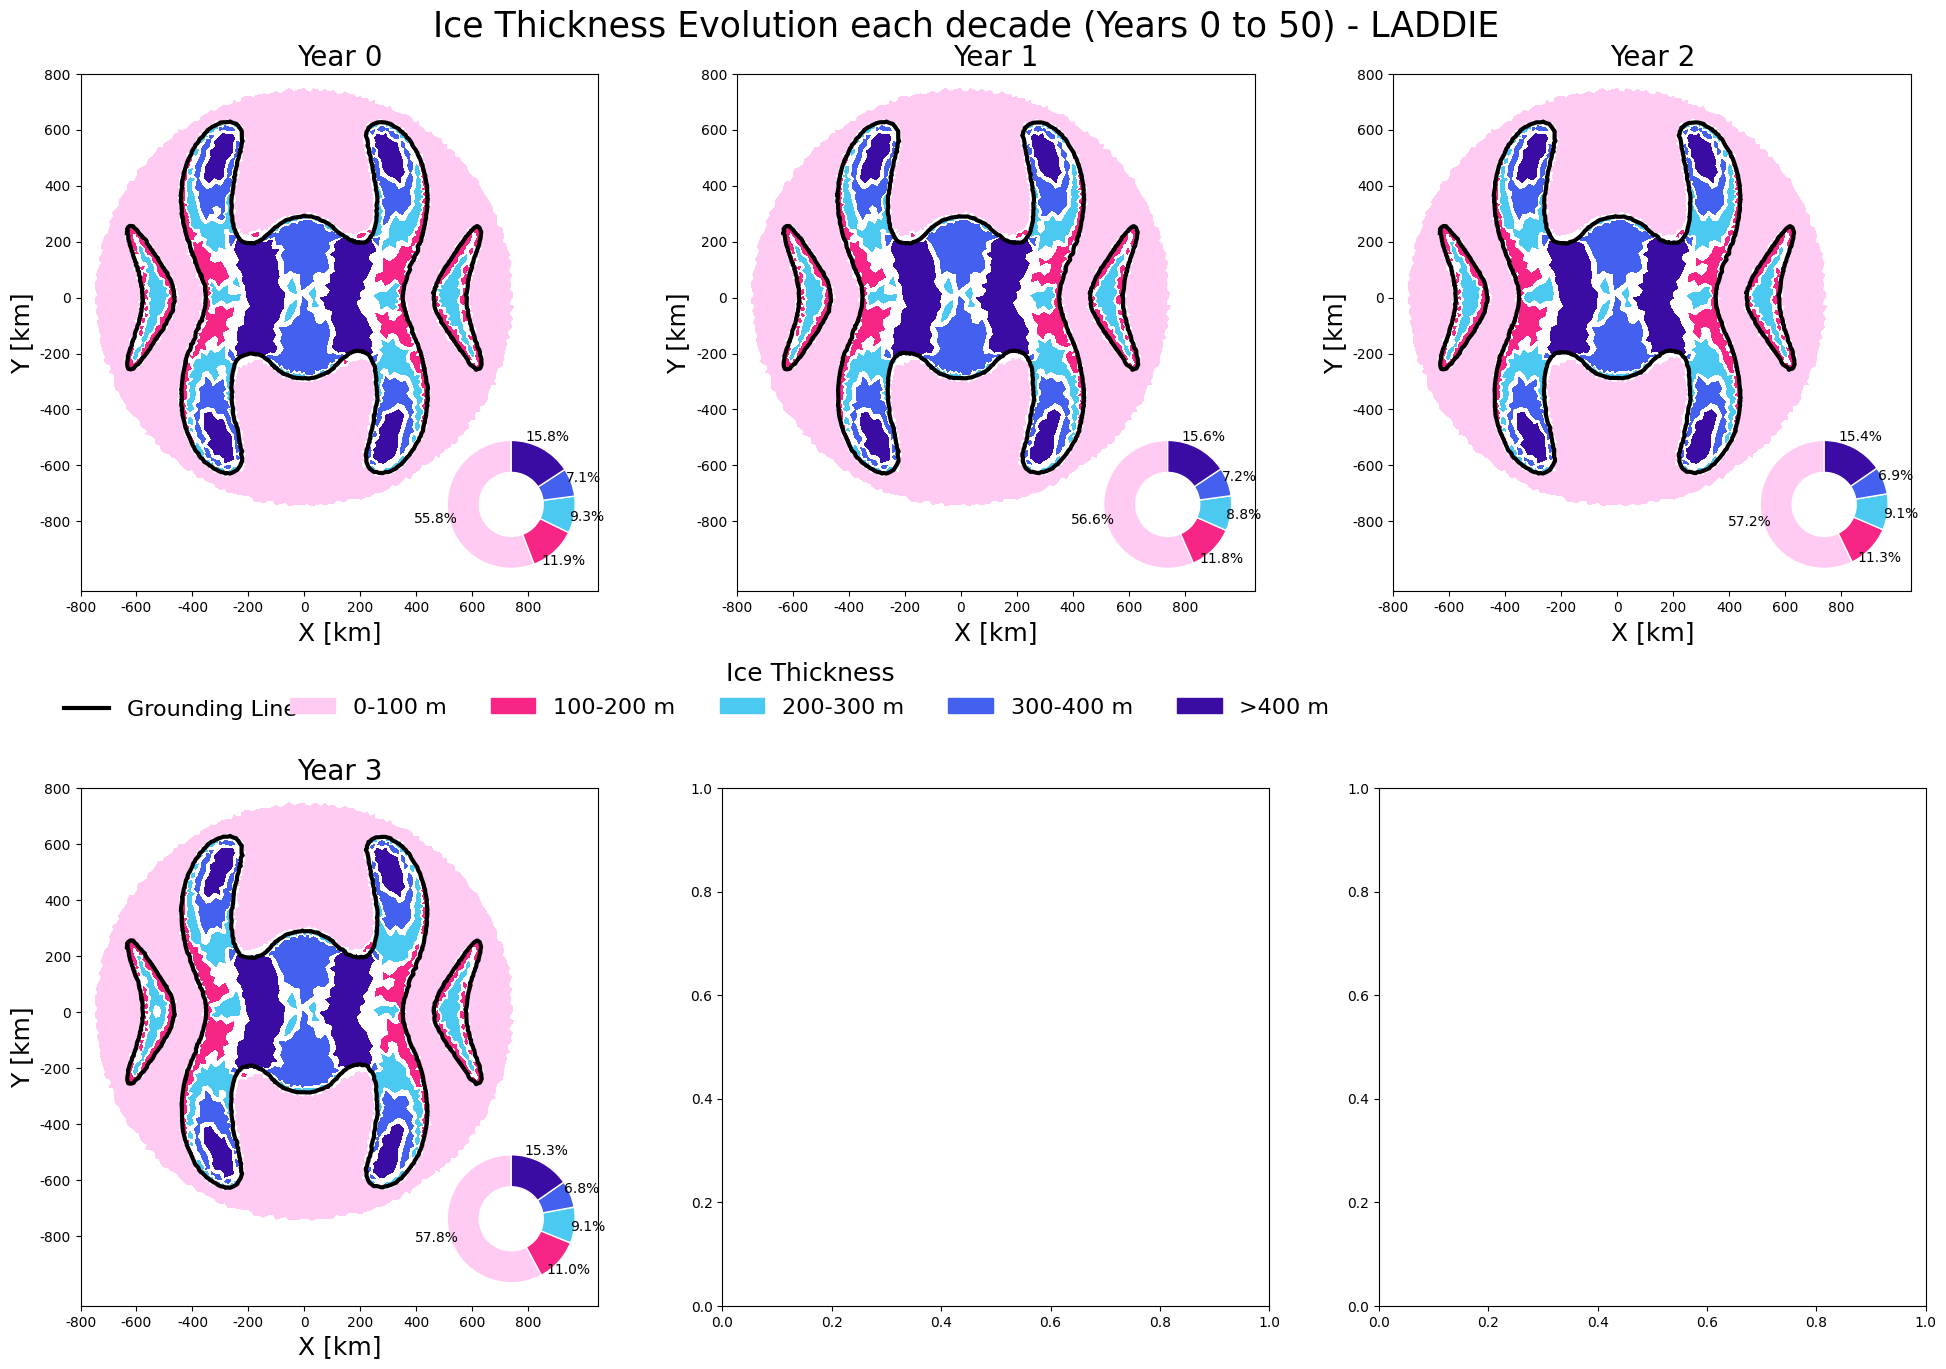

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import Delaunay

def calculate_area_percentages(V, Hi, ranges):
    """
    Calculate percentage of area for each thickness range.
    
    Args:
        V: Array of vertices (N, 2)
        Hi: Array of thickness values (N,)
        ranges: List of tuples defining ranges [(min1, max1), (min2, max2), ...]
    
    Returns:
        List of area percentages for all ranges
    """
    # Convert inputs and remove NaN values
    vertices = np.asarray(V)
    thickness = np.asarray(Hi)
    valid_mask = ~np.isnan(thickness)
    vertices = vertices[valid_mask]
    thickness = thickness[valid_mask]
    
    # Return zeros if we don't have enough points for triangulation
    if len(vertices) < 3:
        return [0.0] * len(ranges)
    
    try:
        tri = Delaunay(vertices)
    except:
        # Return zeros if triangulation fails
        return [0.0] * len(ranges)
    
    # Get triangles and their properties
    triangles = tri.points[tri.simplices]
    tri_values = thickness[tri.simplices]
    tri_means = np.mean(tri_values, axis=1)
    
    # Calculate triangle areas
    a = triangles[:, 1] - triangles[:, 0]
    b = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.abs(a[:,0]*b[:,1] - a[:,1]*b[:,0])
    total_area = np.sum(areas)
    
    if total_area == 0:
        return [0.0] * len(ranges)
    
    # Calculate area percentages for each range
    percentages = []
    for min_val, max_val in ranges:
        in_range = (tri_means >= min_val) & (tri_means < max_val)
        range_area = np.sum(areas[in_range])
        percentages.append((range_area / total_area) * 100)
    
    return percentages

# Define colors and ranges
solid_colors = {
    '0-100': '#FFCBF2',
    '100-200': '#F72585',
    '200-300': '#4CC9F0',
    '300-400': '#4361EE',
    '>400': '#3A0CA3'
}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
    (400, float('inf'))
]

# Create colormaps
cmap_red = ListedColormap([solid_colors['0-100']])
cmap_orange = ListedColormap([solid_colors['100-200']])
cmap_blue = ListedColormap([solid_colors['200-300']])
cmap_purple = ListedColormap([solid_colors['300-400']])
cmap_grey = ListedColormap([solid_colors['>400']])

# Create figure
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]

for i, year in enumerate(years):
    ax = axes[i]
    
    # Plot ice thickness
    c4 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] > 0) & (Hi_l[year] < 100)), cmap=cmap_red)
    c3 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 100) & (Hi_l[year] < 200)), cmap=cmap_orange)
    c2 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 200) & (Hi_l[year] < 300)), cmap=cmap_blue)
    c1 = ax.tripcolor(triang, Hi_l[year].where((Hi_l[year] >= 300) & (Hi_l[year] < 400)), cmap=cmap_purple)
    c0 = ax.tripcolor(triang, Hi_l[year].where(Hi_l[year] >= 400), cmap=cmap_grey)
    
    # Plot grounding line
    GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')
    
    # Calculate area-weighted percentages
    percentages = calculate_area_percentages(V, Hi_l[year].where(mask50 & mask_ocean), ranges)
    
    # Prepare pie chart data
    sizes = percentages
    colors = list(solid_colors.values())
    
    # Add pie chart in bottom right
    pie_ax = inset_axes(ax, width=1.6, height=1.6, loc='lower right',
                       bbox_to_anchor=(1, 0.0), bbox_transform=ax.transAxes)
    
    if np.sum(sizes) > 0:
        wedges, texts = pie_ax.pie(sizes, colors=colors, startangle=90,
                                 wedgeprops=dict(width=0.5, edgecolor='w'))
        
        # Add percentage labels
        for j, wedge in enumerate(wedges):
            if sizes[j] > 5:  # Only show label if percentage > 5%
                angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
                x = 1.2 * np.cos(np.deg2rad(angle))
                y = 1.2 * np.sin(np.deg2rad(angle))
                pie_ax.text(x, y, f'{sizes[j]:.1f}%', ha='center', va='center', fontsize=10)
    else:
        pie_ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        pie_ax.set_xticks([])
        pie_ax.set_yticks([])
    
    # Set main plot properties
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+150000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

ax.legend(loc='upper left', bbox_to_anchor=(-0.07, 1.21), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.40, 0.5),
                         title_fontsize=18)

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - LADDIE', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

In [62]:
V_array = np.asarray(V) 
Hi_values = Hi_l[50].where(mask50 & mask_ocean).values.flatten()

Hi_mean = area_weighted_average(V_array, Hi_values)
print(f"Area-weighted average ice thickness: {Hi_mean:.2f} m")

Area-weighted average ice thickness: 262.32 m


In [88]:
# Calculate percentages
percentages = calculate_area_percentages(V, Hi_l[0].where(mask50 & mask_ocean), ranges)

# Print results
for (min_val, max_val), perc in zip(ranges, percentages):
    print(f"{min_val}-{max_val}m: {perc:.2f}%")

0-100m: 2.30%
100-200m: 13.82%
200-300m: 18.01%
300-400m: 21.75%
0-400m: 55.88%
400-infm: 44.12%


In [91]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Data range: 0.0 to 700.0 m


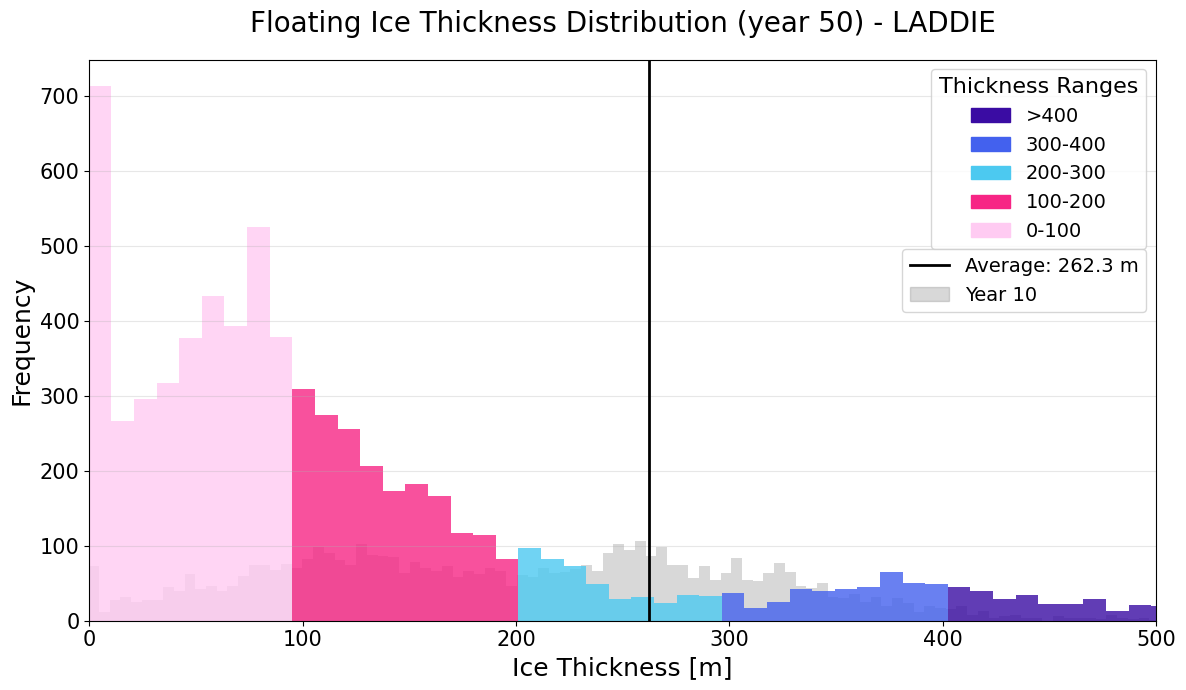

In [92]:
# Your custom color bins
solid_colors = {
    '>400': '#3A0CA3',   # Deep blue
    '300-400': '#4361EE', # Bright blue
    '200-300': '#4CC9F0', # Light teal-blue
    '100-200': '#F72585', # Vibrant pink
    '0-100': '#FFCBF2'    # Light pink
}

# Load your data for both years
data_year50 = Hi_l[50].where(mask50 & mask_ocean).values.flatten()
data_year50 = data_year50[~np.isnan(data_year50)]  # Remove NaN values

data_year0 = Hi_l[10].where(mask10 & mask_ocean).values.flatten()
data_year0 = data_year0[~np.isnan(data_year0)]  # Remove NaN values

# Calculate data range
data_min, data_max = 0, 700
print(f"Data range: {data_min:.1f} to {data_max:.1f} m")  # Verify range matches expectations

# Create figure
plt.figure(figsize=(12, 7))

# Set number of bins
num_bins = 150

# First plot the year 0 distribution in background (faded)
n0, bins0, patches0 = plt.hist(data_year0, bins=num_bins, 
                              edgecolor='none', 
                              alpha=0.3,  # More transparent
                              color='gray',  # Unified faded color
                              label='Year 0 Distribution')

# Then plot the year 50 distribution
n50, bins50, patches50 = plt.hist(data_year50, bins=num_bins, 
                                edgecolor='none', 
                                alpha=0.8)

# Color each bar according to your thresholds (only for year 50)
for patch, bin_left, bin_right in zip(patches50, bins50[:-1], bins50[1:]):
    bin_center = (bin_left + bin_right)/2
    
    if bin_center > 400:
        patch.set_facecolor(solid_colors['>400'])
    elif bin_center > 300:
        patch.set_facecolor(solid_colors['300-400'])
    elif bin_center > 200:
        patch.set_facecolor(solid_colors['200-300'])
    elif bin_center > 100:
        patch.set_facecolor(solid_colors['100-200'])
    else:
        patch.set_facecolor(solid_colors['0-100'])

# Add statistical markers (for year 50)
average = Hi_mean
avg_line = plt.axvline(x=average, color='black', linestyle='-', linewidth=2)

# Create combined legend
from matplotlib.lines import Line2D

# Color range patches
color_patches = [mpatches.Patch(color=color, label=label) 
                for label, color in solid_colors.items()]

# Statistical line markers
stat_lines = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label=f'Average: {average:.1f} m'),
    mpatches.Patch(color='gray', alpha=0.3, label='Year 10 ')
]

# Combine all legends
first_legend = plt.legend(handles=color_patches, 
                         bbox_to_anchor=(0.78, 1), 
                         loc='upper left',
                         title='Thickness Ranges', 
                         fontsize=14, 
                         title_fontsize=16)

# Add the second legend manually
plt.gca().add_artist(first_legend)
plt.legend(handles=stat_lines, 
          bbox_to_anchor=(0.753, 0.68), 
          loc='upper left', 
          fontsize=14)

# Format plot
plt.title('Floating Ice Thickness Distribution (year 50) - LADDIE', 
          fontsize=tfs, pad=20)
plt.xlabel('Ice Thickness [m]', fontsize =afs)
plt.xticks(fontsize=tifs)
plt.yticks(fontsize=tifs)
plt.ylabel('Frequency', fontsize=afs)
plt.grid(axis='y', alpha=0.3)
plt.xlim(max(0, data_min*0.9), min(500, data_max*1.1))

plt.tight_layout()
plt.show()

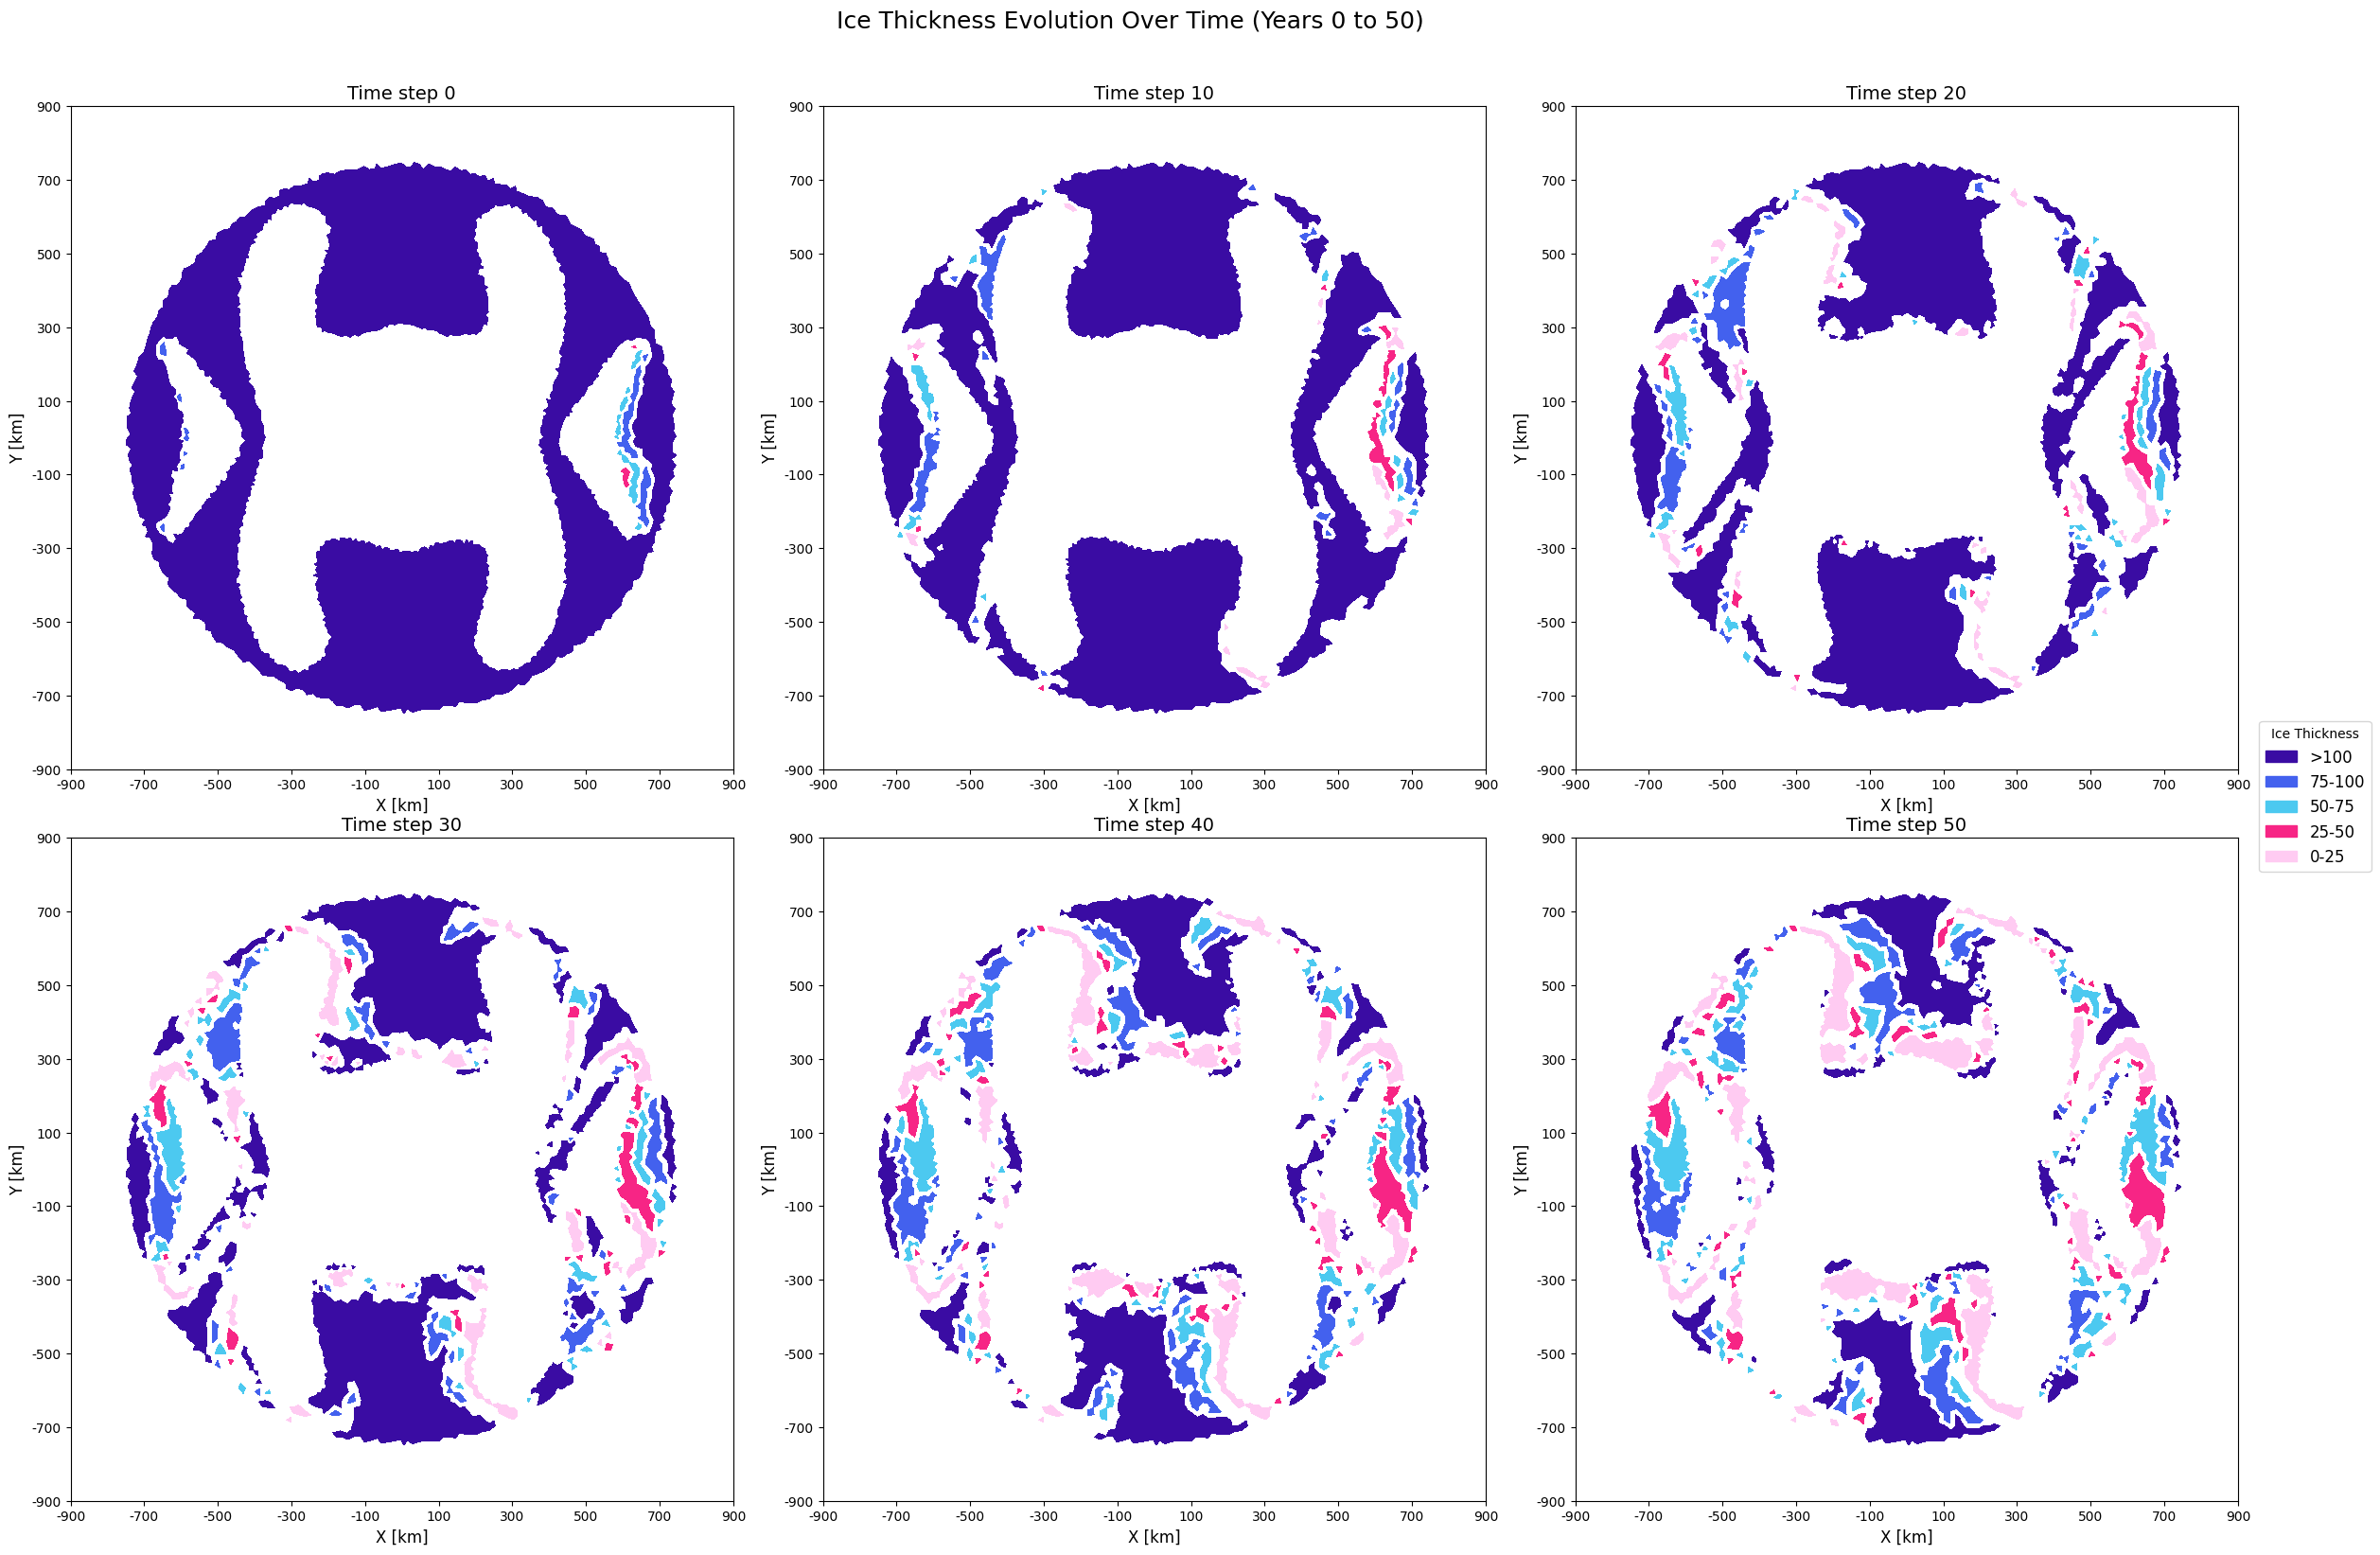

In [25]:
solid_colors = {
    '>400': '#3A0CA3',   # Deep blue
    '300-400': '#4361EE', # Bright blue
    '200-300': '#4CC9F0', # Light teal-blue
    '100-200': '#F72585', # Vibrant pink
    '0-100': '#FFCBF2'    # Light pink
}

# Create colormaps
cmap_grey = ListedColormap([solid_colors['>400']])
cmap_purple = ListedColormap([solid_colors['300-400']])
cmap_blue = ListedColormap([solid_colors['200-300']])
cmap_orange = ListedColormap([solid_colors['100-200']])
cmap_red = ListedColormap([solid_colors['0-100']])

n = 900000
years = [0, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

# Create legend handles
legend_handles = [
    mpatches.Patch(color=solid_colors['>400'], label='>100'),
    mpatches.Patch(color=solid_colors['300-400'], label='75-100'),
    mpatches.Patch(color=solid_colors['200-300'], label='50-75'),
    mpatches.Patch(color=solid_colors['100-200'], label='25-50'),
    mpatches.Patch(color=solid_colors['0-100'], label='0-25')
]


for i, year in enumerate(years):
    ax = axes[i]
    p = 0.01
    mask_floating = (Hs_l[year] - Hi_l[year] - Hb_l[year] <= p)
    mask_rock= ~mask_floating
    Hi = Hi_l[year].where(mask_ocean & mask_rock)  
    c0 = ax.tripcolor(triang,Hi.where(Hi > 100), cmap=cmap_grey)
    c1 = ax.tripcolor(triang,Hi.where((Hi > 75) & (Hi < 100)), cmap=cmap_purple)
    c2 = ax.tripcolor(triang,Hi.where((Hi > 50) & (Hi < 75)), cmap=cmap_blue)
    c3 = ax.tripcolor(triang,Hi.where((Hi > 25) & (Hi < 50)), cmap=cmap_orange)
    c4 = ax.tripcolor(triang, Hi.where((Hi > 0) & (Hi < 25)), cmap=cmap_red)

    ax.set_title(f'Time step {year}', fontsize=14)
    ax.set_xlabel('X [km]', fontsize=12)
    ax.set_ylabel('Y [km]', fontsize=12)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')

# Add a single legend to the right of all subplots
fig.legend(handles=legend_handles, 
           title='Ice Thickness', 
           loc='right', 
           bbox_to_anchor=(1.05, 0.5), 
           fontsize=12)

plt.suptitle('Ice Thickness Evolution Over Time (Years 0 to 50)', 
             fontsize=18, y=1.02)  

plt.tight_layout()
plt.show()

In [26]:
plt.close('all')

## Basal melting 

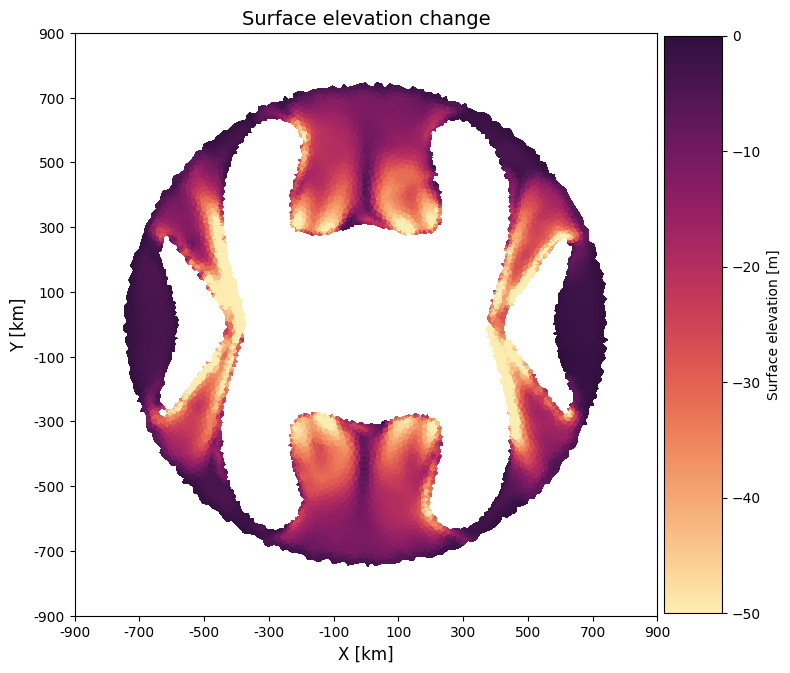

In [27]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (BMB_l[0]).where(mask_ocean & mask0), cmap=cmo.matter, vmin=-50, vmax=0)
fig.colorbar(c0, ax=ax, label="Surface elevation [m]", **colorbar_kwargs)
ax.set_title('Surface elevation change', fontsize=14)

ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

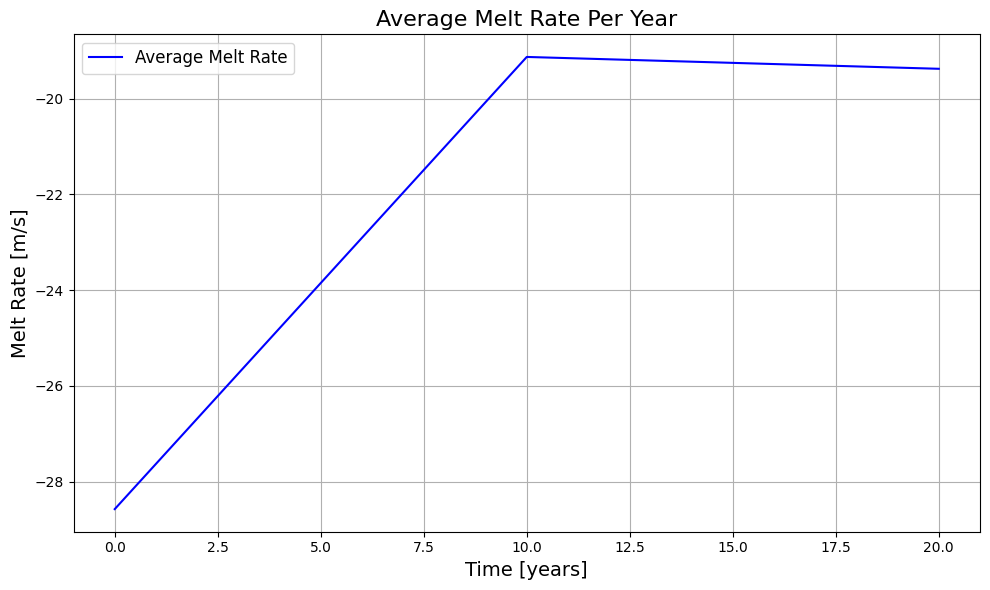

In [254]:
# Calculate the average melt rate per year
average_melt_rate = BMB_l.where(mask10 & mask_ocean & (Hib_l<-300)).mean(dim='vi')

# Plot the average melt rate
plt.figure(figsize=(10, 6))
plt.plot(BMB_l['time'], average_melt_rate, label='Average Melt Rate', color='blue')
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('Melt Rate [m/s]', fontsize=14)
plt.title('Average Melt Rate Per Year', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [151]:
V_array = np.asarray(V) 

results = []
for u in range(len(Lad1['time'])):
    BMB = BMB_l[u].where(mask0 & mask_ocean)
    BMB = BMB.where(Hib_l[u] < -300) 
    BMB = BMB.where((V_array[:, 0] > -230000) & (V_array[:, 0] < 230000)).values.flatten()
    B = area_weighted_average(V_array, BMB)
    results.append(B)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Lad1['time'], results, marker='o', label='Area-weighted average BMB')
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('Area-weighted average BMB [m/yr]', fontsize=14)
plt.title('Evolution of Area-weighted Average Basal Mass Balance', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


ValueError: Delaunay triangulation failed - check for duplicate points or colinearities

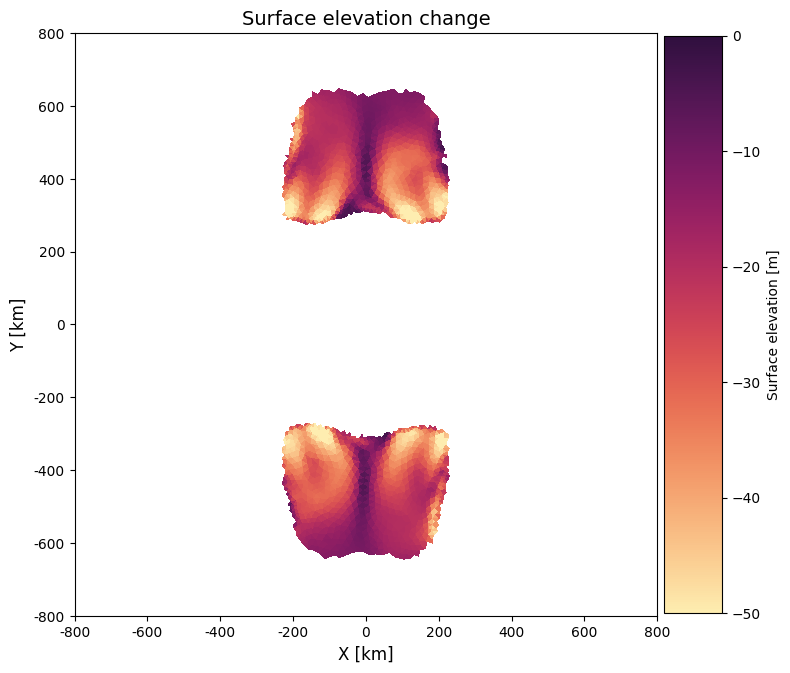

In [147]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (BMB).where(mask_ocean & mask0), cmap=cmo.matter, vmin=-50, vmax=0)
fig.colorbar(c0, ax=ax, label="Surface elevation [m]", **colorbar_kwargs)
ax.set_title('Surface elevation change', fontsize=14)

ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [29]:
BMB =  BMB_l[0].where(mask_ocean & mask0 & (Hib_l[0] <(-300)))
BMB.mean().values

array(-29.62830741)

In [38]:
mask10 = mask_rock(Hs_l, Hi_l, Hb_l, 10)

TypeError: 'DataArray' object is not callable

/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_26556/1310118439.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)  # Reduced padding


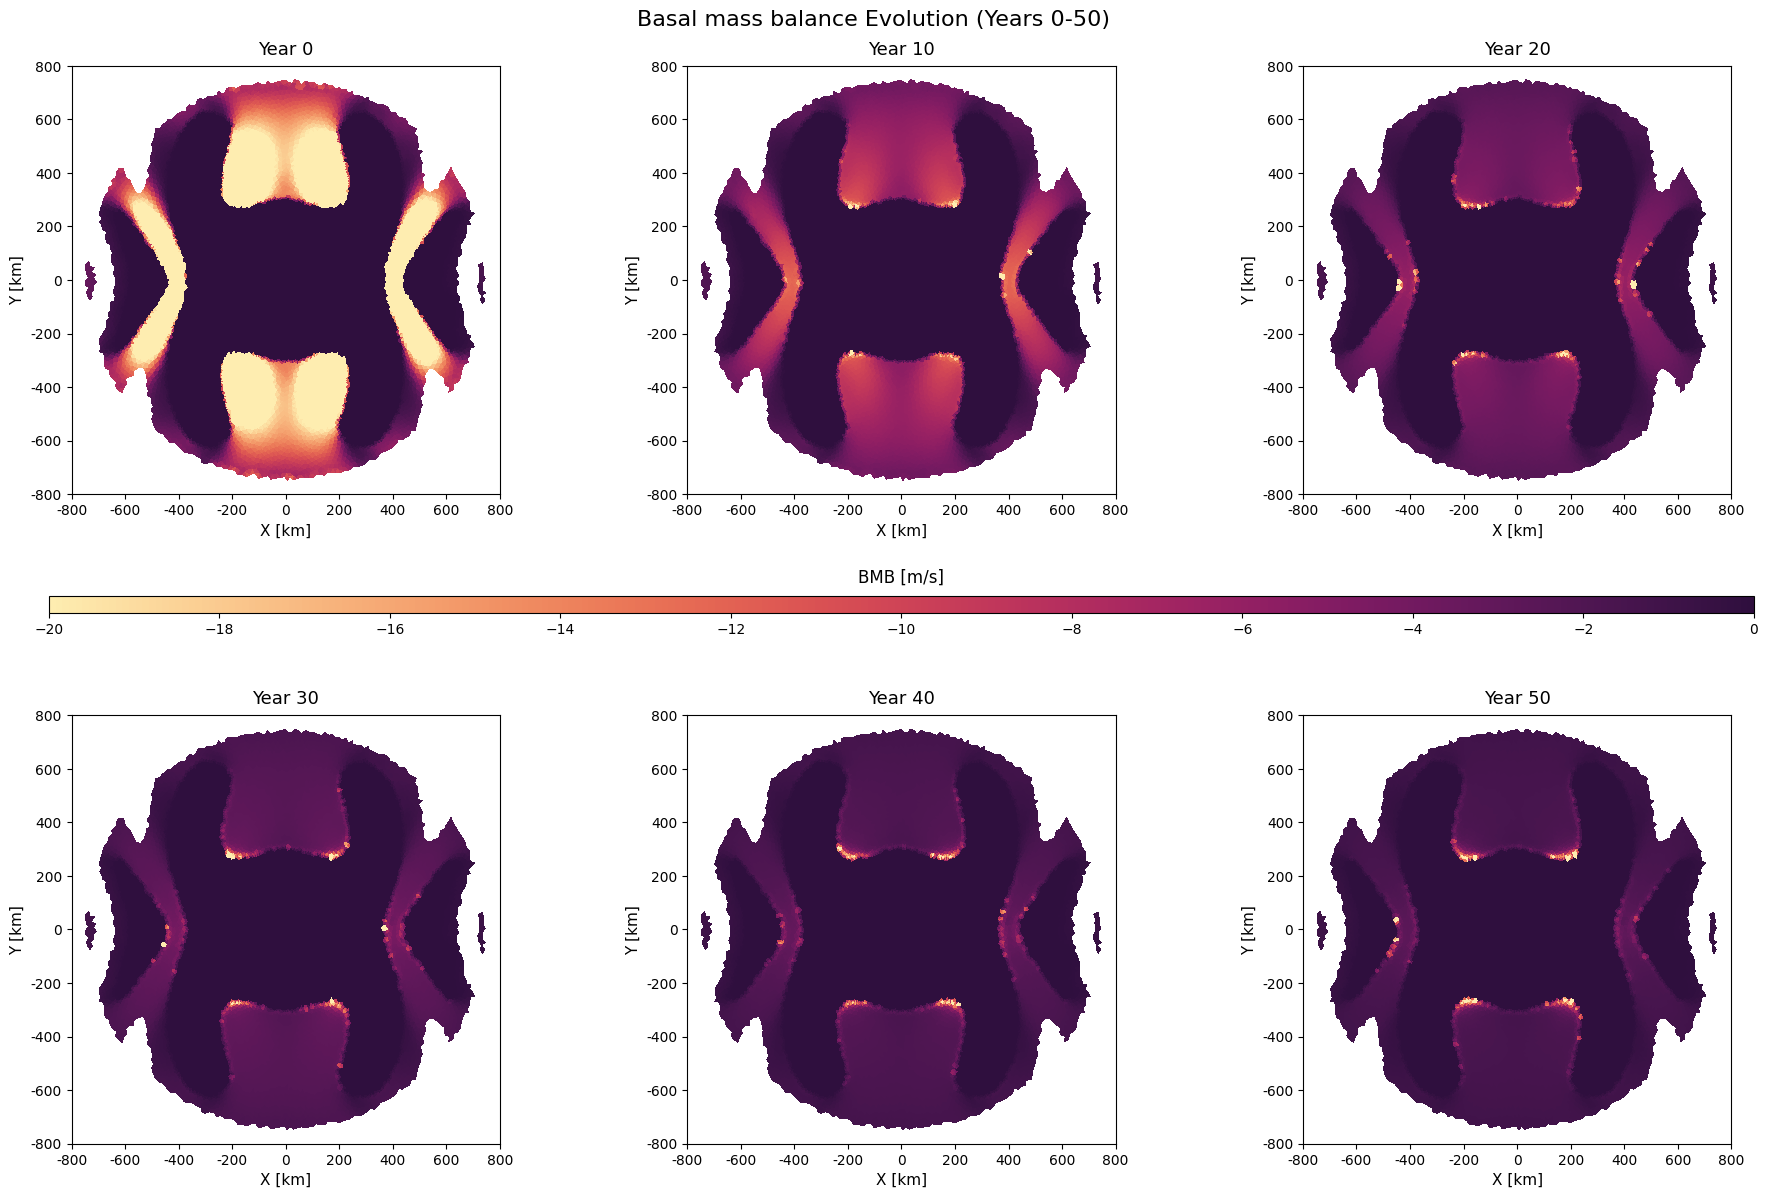

In [ ]:
fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]
     # Mask for grounded ice
    # Main plot with contour lines
    c0 = ax.tripcolor(triang, BMB_l[year].where(mask10 & mask_ocean), cmap=cmo.matter, vmin=-20, vmax=0)
    #contours = ax.tricontour(triang, Hi_l[year].where(mask_rock), 
    #                        levels=np.arange(0, 301, 50), 
    #                        colors='k', linewidths=0.7)  # Darker contours
    #ax.clabel(contours, inline=True, fontsize=9, fmt='%d m')
    
    # Axis formatting
    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')

# Colorbar formatting
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('BMB [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(-20, 0, 11))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('Basal mass balance Evolution (Years 0-50)', 
            fontsize=16, y=0.92)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()

In [ ]:
plt.close('all')

## Decades


/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_8492/2057667883.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)  # Reduced padding


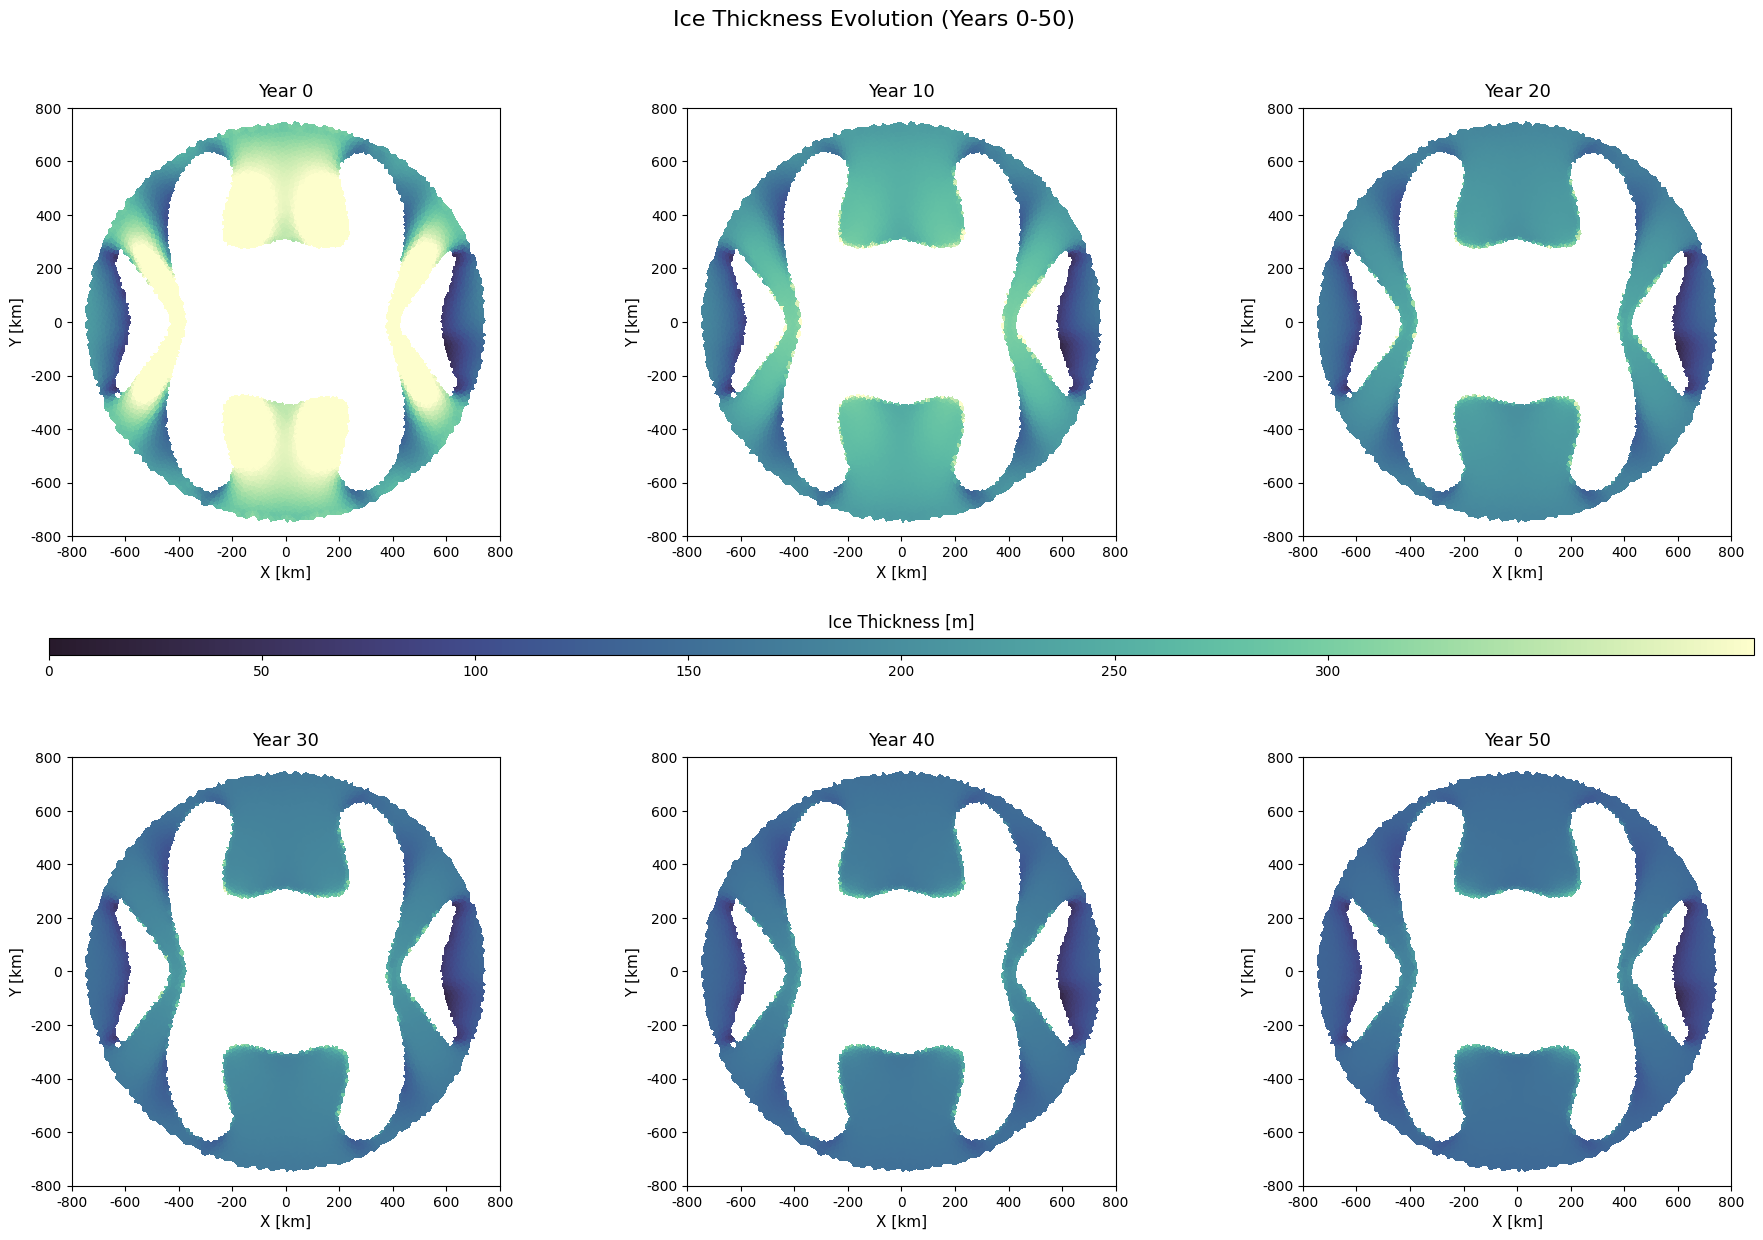

In [ ]:
fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]
    # Main plot with contour lines
    c0 = ax.tripcolor(triang, Hi_l[year].where(mask_rock&mask_ocean), cmap=cmo.deep_r, vmin=0, vmax=400)

    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')
    # Colorbar formatting
    cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
    cbar.set_label('Ice Thickness [m]', fontsize=12, labelpad=8)
    cbar.set_ticks(np.arange(0, 301, 50))  # Match contour levels
    cbar.ax.tick_params(labelsize=10)  # Adjust tick label size
    cax.xaxis.set_ticks_position('bottom')
    cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('Ice Thickness Evolution (Years 0-50)', 
            fontsize=16, y=0.95)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()

/var/folders/bv/2cj65x2j5v94fp020tpswb0w0000gn/T/ipykernel_3990/1811847402.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)  # Reduced padding


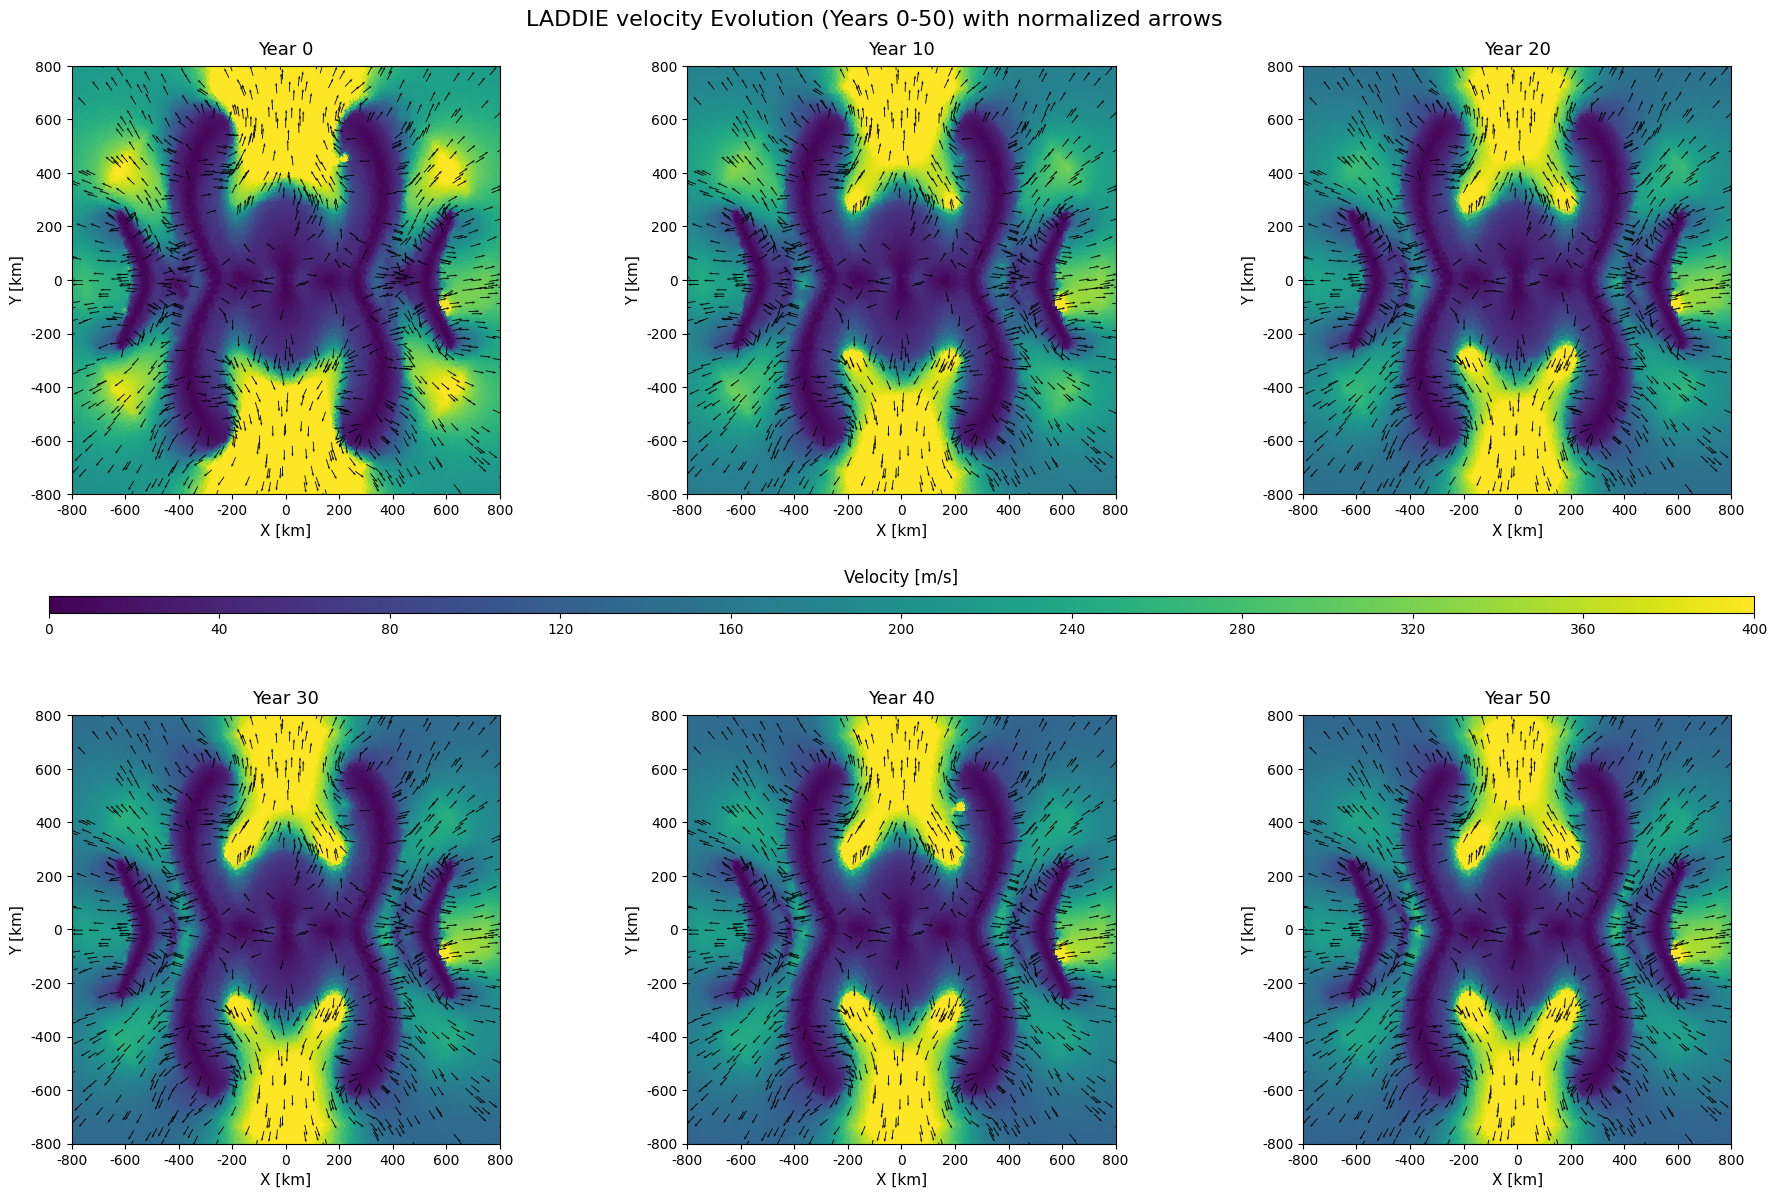

In [ ]:
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}

m = 20
Tricc = Lad['Tricc']

fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]

    # Main plot with contour lines
    c0 = ax.tripcolor(
        Tricc[0, :], 
        Tricc[1, :], 
        magice[year], 
        cmap='viridis', 
        vmin=0, 
        vmax=400

    )
    # Axis formatting
    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')


    u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
    v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


    ax.quiver(Tricc[0, :][::m],
        Tricc[1, :][::m],
        u_s_norm,
        v_s_norm,
        scale=40,
        width=0.002,
        headwidth=3,
        headlength=4,
        headaxislength=3
    )


# Colorbar formatting
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(0, 400, 11))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('LADDIE velocity Evolution (Years 0-50) with normalized arrows', 
            fontsize=16, y=0.92)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()


In [ ]:
Tricc = Lad['Tricc']
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}
u = 50
m = 10



##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(16, 8)) 

c0 = ax.tripcolor(
    Tricc[0, :], 
    Tricc[1, :], 
    magice[u], 
    cmap='viridis', 
    vmin=0, 
    vmax=400

)

fig.colorbar(c0, ax=ax, label="Velocity magnitude [m/y]", **colorbar_kwargs)
ax.set_title('Ice velocity', fontsize=14)


u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


plt.quiver(Tricc[0, :][::m],
    Tricc[1, :][::m],
    u_s_norm,
    v_s_norm,
    scale=50,
    width=0.002,
    headwidth=3,
    headlength=4,
    headaxislength=3
)

plt.quiverkey(
    plt.quiver(0, 0, 0, 0, scale=10000, width=0.002),
    X=0.75,
    Y=0.97,
    U= 200,
    label=' Normalized quivers',
    labelpos='E',
    coordinates='figure',
    color='k'
)

ax.set_aspect('equal')
ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)

plt.tight_layout()
plt.show()

In [ ]:
plt.close('all')

In [47]:
L = Lad['grounding_line'][0]
L50 = Lad['grounding_line'][50]

plt.figure(figsize=(6, 6))
plt.plot(L[0, :], L[1, :], label='GL (Year 0)', color='blue')
plt.plot(L50[0, :], L50[1, :], label='GL (Year 50)', color='red')

plt.title('Grounding Line Evolution', fontsize=16)
plt.xlabel('X [m]', fontsize=14)
plt.ylabel('Y [m]', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
 # Ensure equal scaling for X and Y axes
plt.xlim(-700000, 700000)
plt.ylim(-700000, 700000)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

NameError: name 'Lad' is not defined

## Laddie extra

In [39]:
def Tocean(d):
    a =(To[-1,1].values - To[0,1].values)/ 1500
    b = To[0,1].values
    return a * d + b
Tocean(-700)

np.float64(-4.719444444444445)

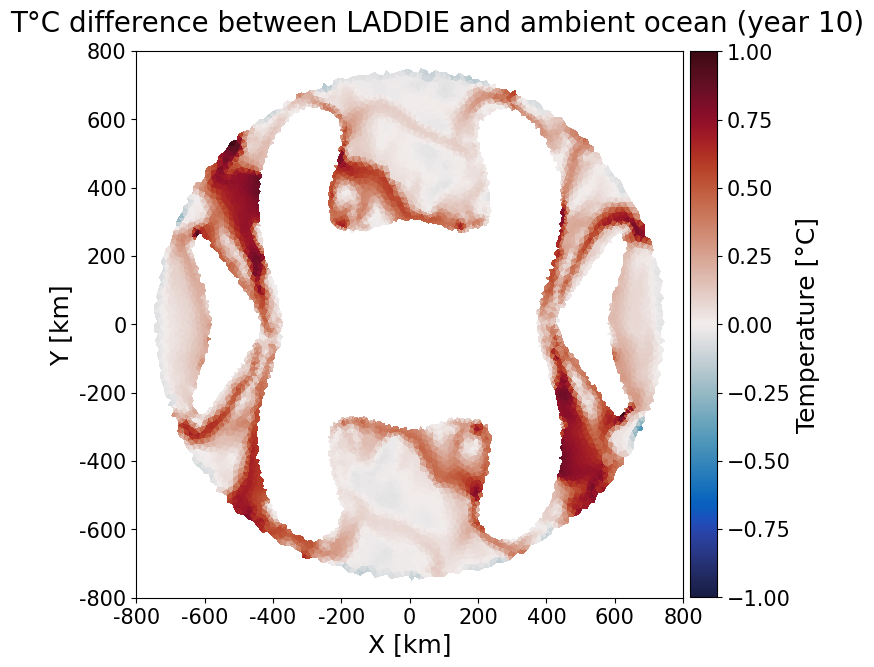

In [45]:
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.72, 
}

n = 800000
u = 10
##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

Temp = Tocean(-(Hib_l[u]-H_lad[u]).where(mask10 & mask_ocean))
Tem = T_lad[u].where(mask10 & mask_ocean)
c0 = ax.tripcolor(triang, Tem-Temp, cmap=cmo.balance, vmin=-1, vmax= 1)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Temperature [°C]", fontsize= cbfs)  # Set fontsize here
cbar.ax.tick_params(labelsize=ctfs)
ax.set_title('T°C difference between LADDIE and ambient ocean (year 10)', fontsize=tfs, x = 0.55, y = 1.02)

ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()